In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import numpy as np
import jax
import jax.numpy as jnp
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
import pytensor.tensor as pt
from scipy.optimize import curve_fit
import arviz as az
import scipy as sp
import xarray as xr
import numpyro

from utils import (
  compute_exposure, get_interval_length, 
  get_last_periods, simulate_data, 
  hill, s_origin, cum_hazard
  )

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.figsize'] = (10, 6)

numpyro.set_host_device_count(8)

In [30]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

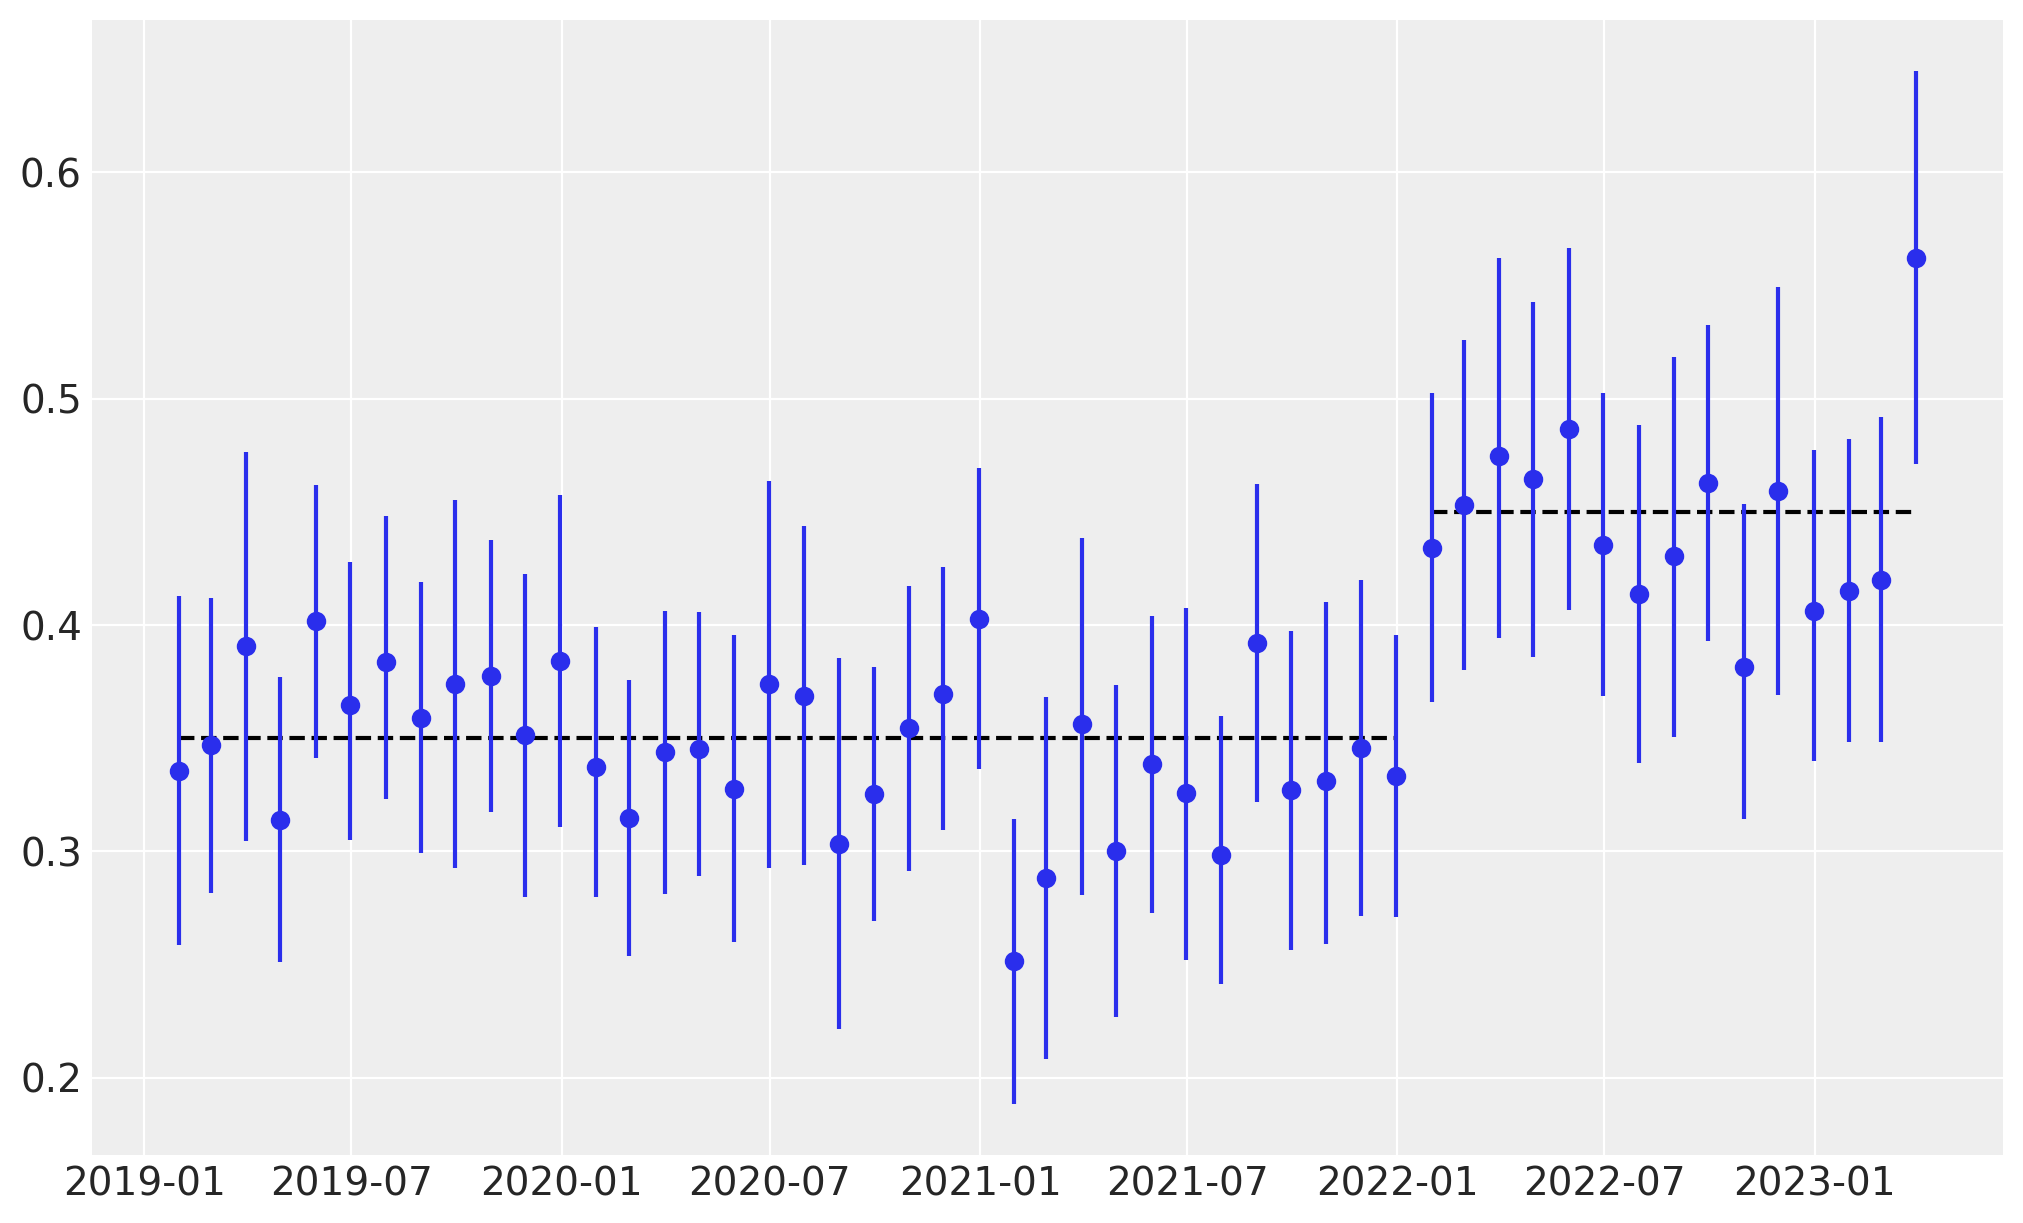

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['N_yes', 'N_no']   No. Observations:                   51
Model:                            GLM   Df Residuals:                       49
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -166.43
Date:                Mon, 01 Apr 2024   Deviance:                       48.961
Time:                        22:08:45   Pearson chi2:                     48.6
No. Iterations:                     4   Pseudo R-squ. (CS):             0.7519
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6330      0.025    -24.921      0.000      -0.683      -0.583
dummy          0.3982      0.047      8.461      0.000       0.306       0.490
==============================================================================
"""

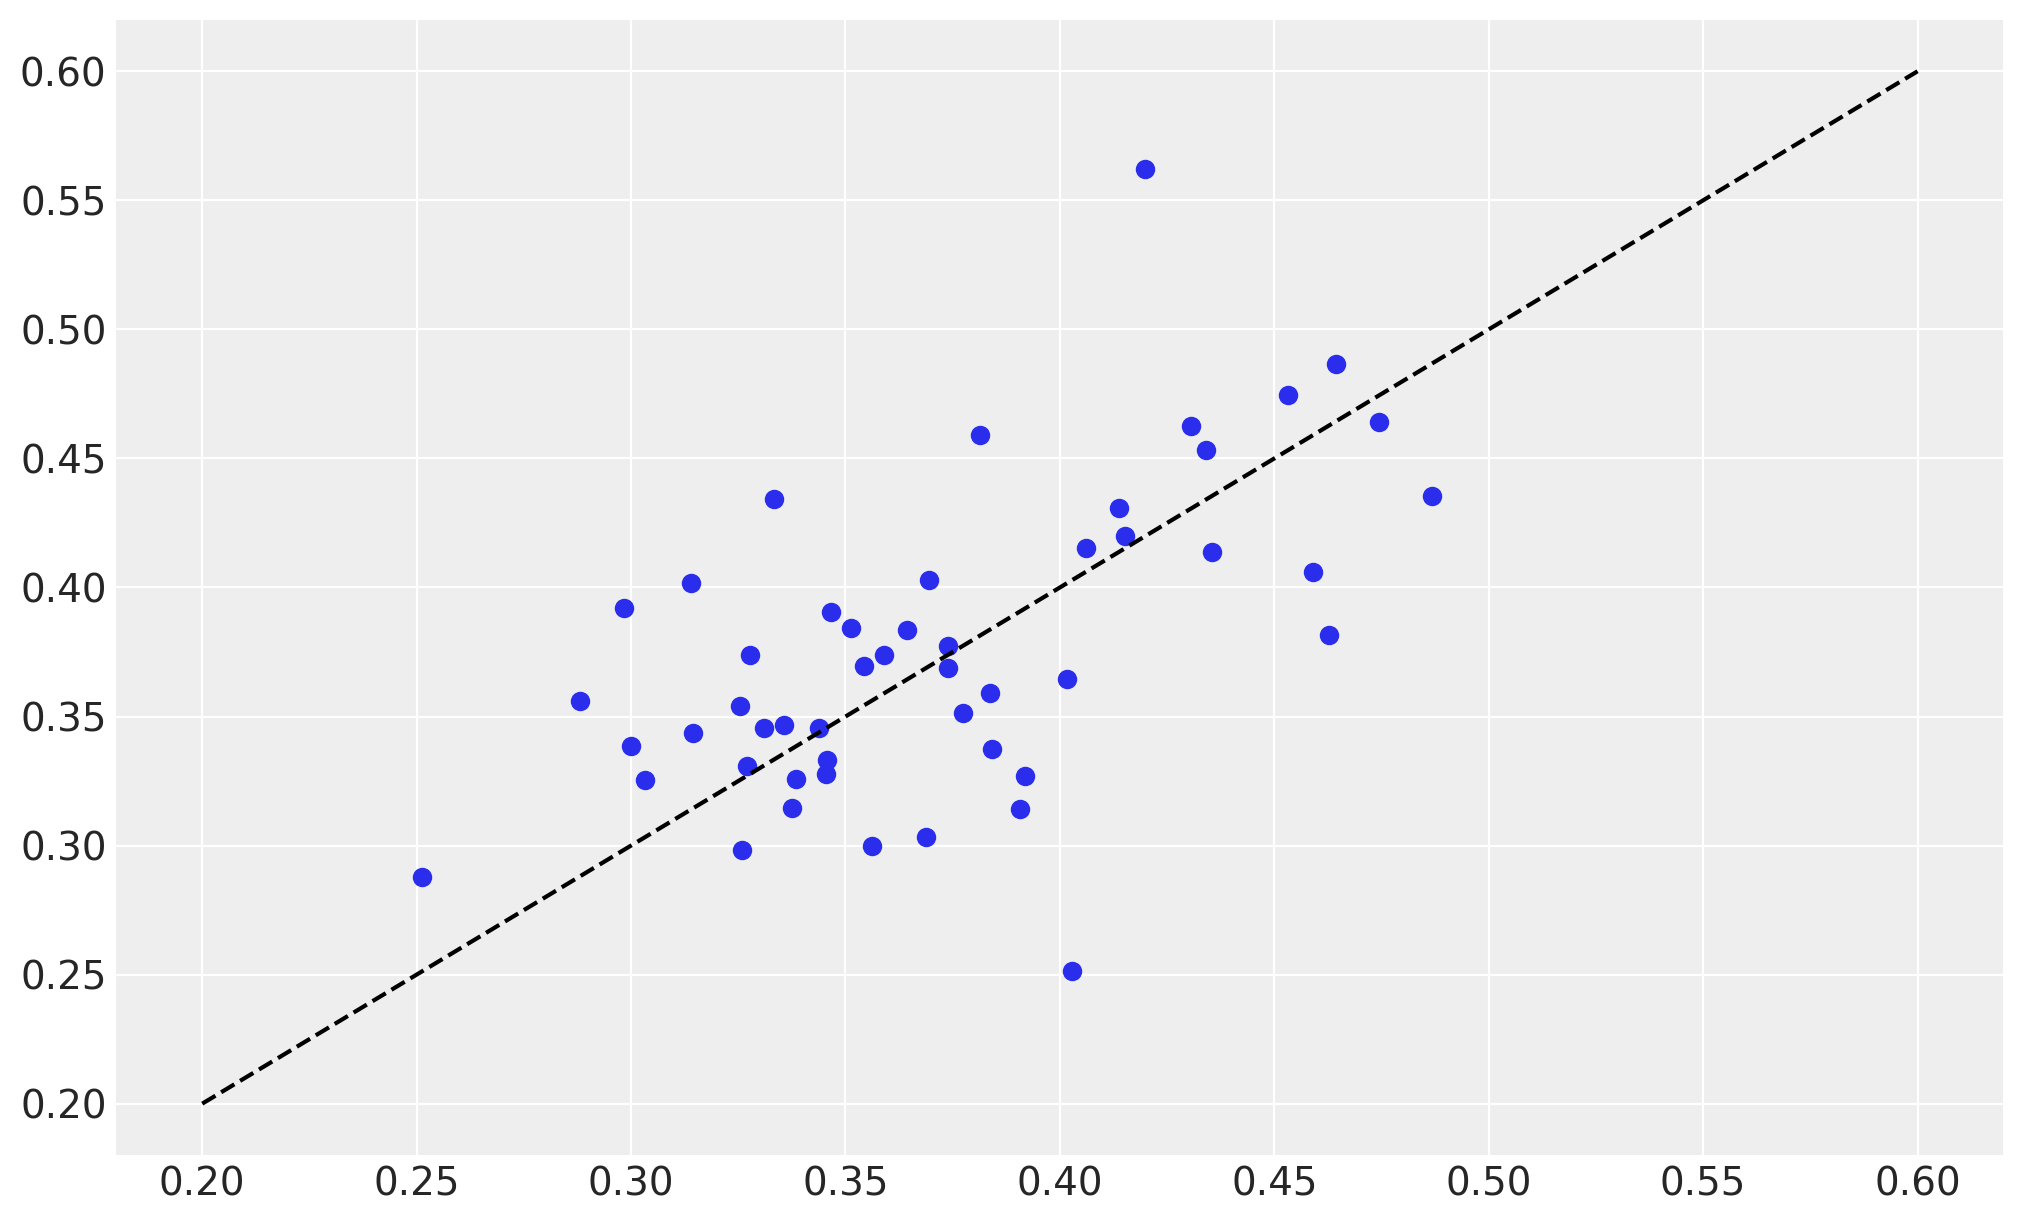

In [84]:
data_points = 12*4+3
sample_sizes = np.random.choice(np.arange(120, 250), size=data_points)
N_yes = np.random.binomial(sample_sizes, p=[.35]*12*3+[.45]*(12*1+3))
obs_frac = N_yes/sample_sizes
date = pd.date_range(start='2019-01-01', periods=data_points, freq='ME')
boot_strap_samples = np.random.binomial(sample_sizes, p=obs_frac, size=(10_000, data_points))
high = np.percentile(boot_strap_samples, 97.5, axis=0)
low = np.percentile(boot_strap_samples, 2.5, axis=0)


plt.plot(date[:12*3], [.35]*12*3, c='k', ls='--')
plt.plot(date[12*3:], [.45]*(12*1+3), c='k', ls='--')
plt.errorbar(date, obs_frac, yerr=[obs_frac-low/sample_sizes, high/sample_sizes-obs_frac], fmt='o')

plt.show()
plt.scatter(x=obs_frac[:-1], y=obs_frac[1:])
plt.plot([.2, .6], [.2, .6], 'k--')
dummy = np.zeros(shape=(data_points,))
dummy[12*3:] = 1
data_binom = pd.DataFrame({'N_yes': N_yes, 'N_no': sample_sizes-N_yes, 'dummy': dummy, 'date': date})
model = sm.GLM(data_binom[['N_yes', "N_no"]], sm.add_constant(data_binom[['dummy']]), family=sm.families.Binomial()).fit()
model.summary()


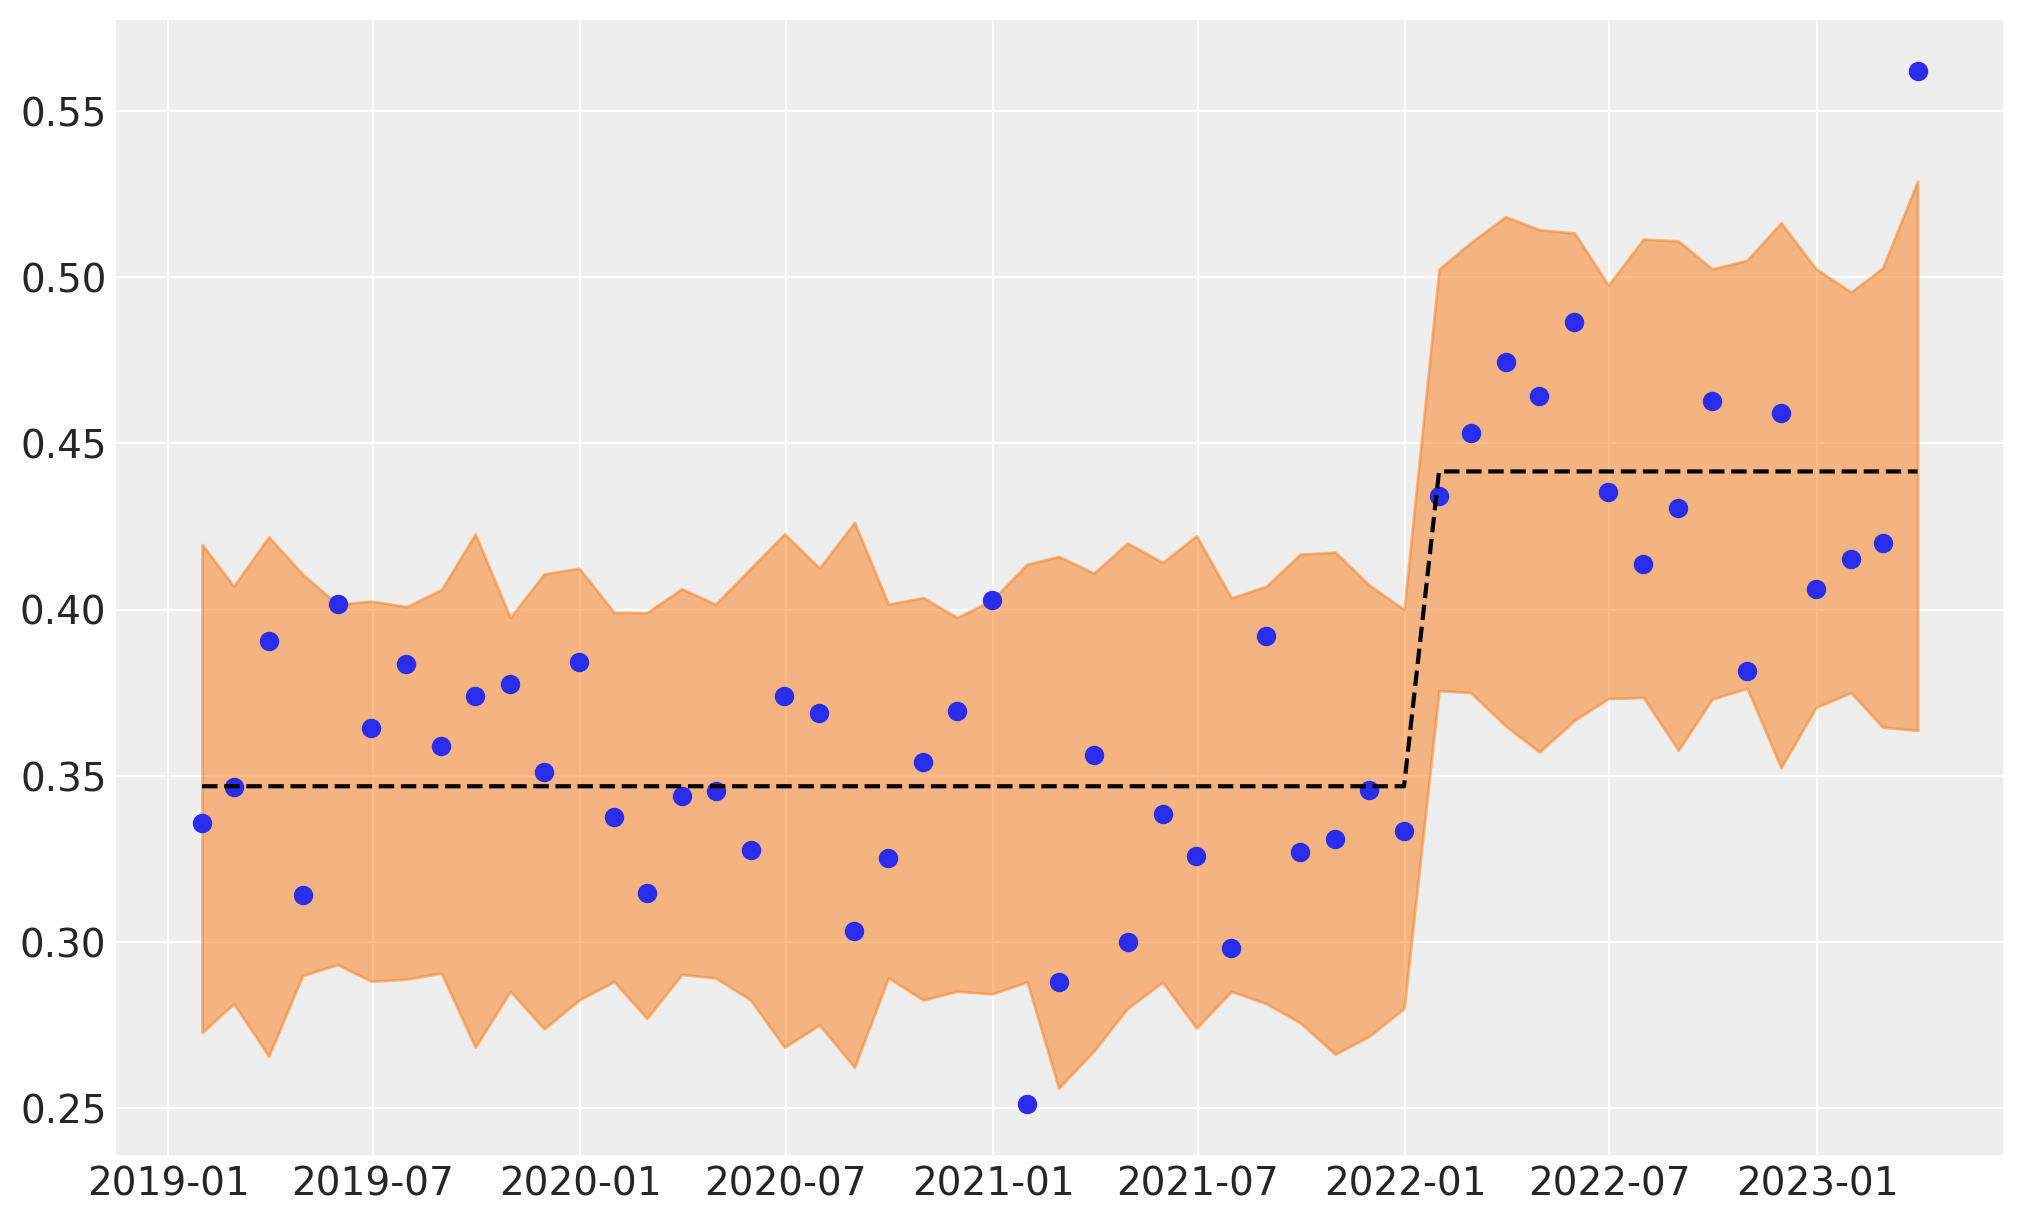

In [85]:
ax = az.plot_hdi(date, model.get_distribution(n_trials=sample_sizes).rvs((4, 1000,51))/sample_sizes, smooth=False)
ax.plot(date, obs_frac, 'o')
ax.plot(date, model.predict(), 'k--')

In [87]:
with pm.Model() as binom:
  p_true = pm.Beta('p_true', alpha=1, beta=1, shape=data_points)
  pm.Binomial('obs', n=sample_sizes, p=p_true, observed=N_yes)
  binom_trace = pm.sample(1000, tune=1000, nuts_sampler='numpyro')
  

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: >

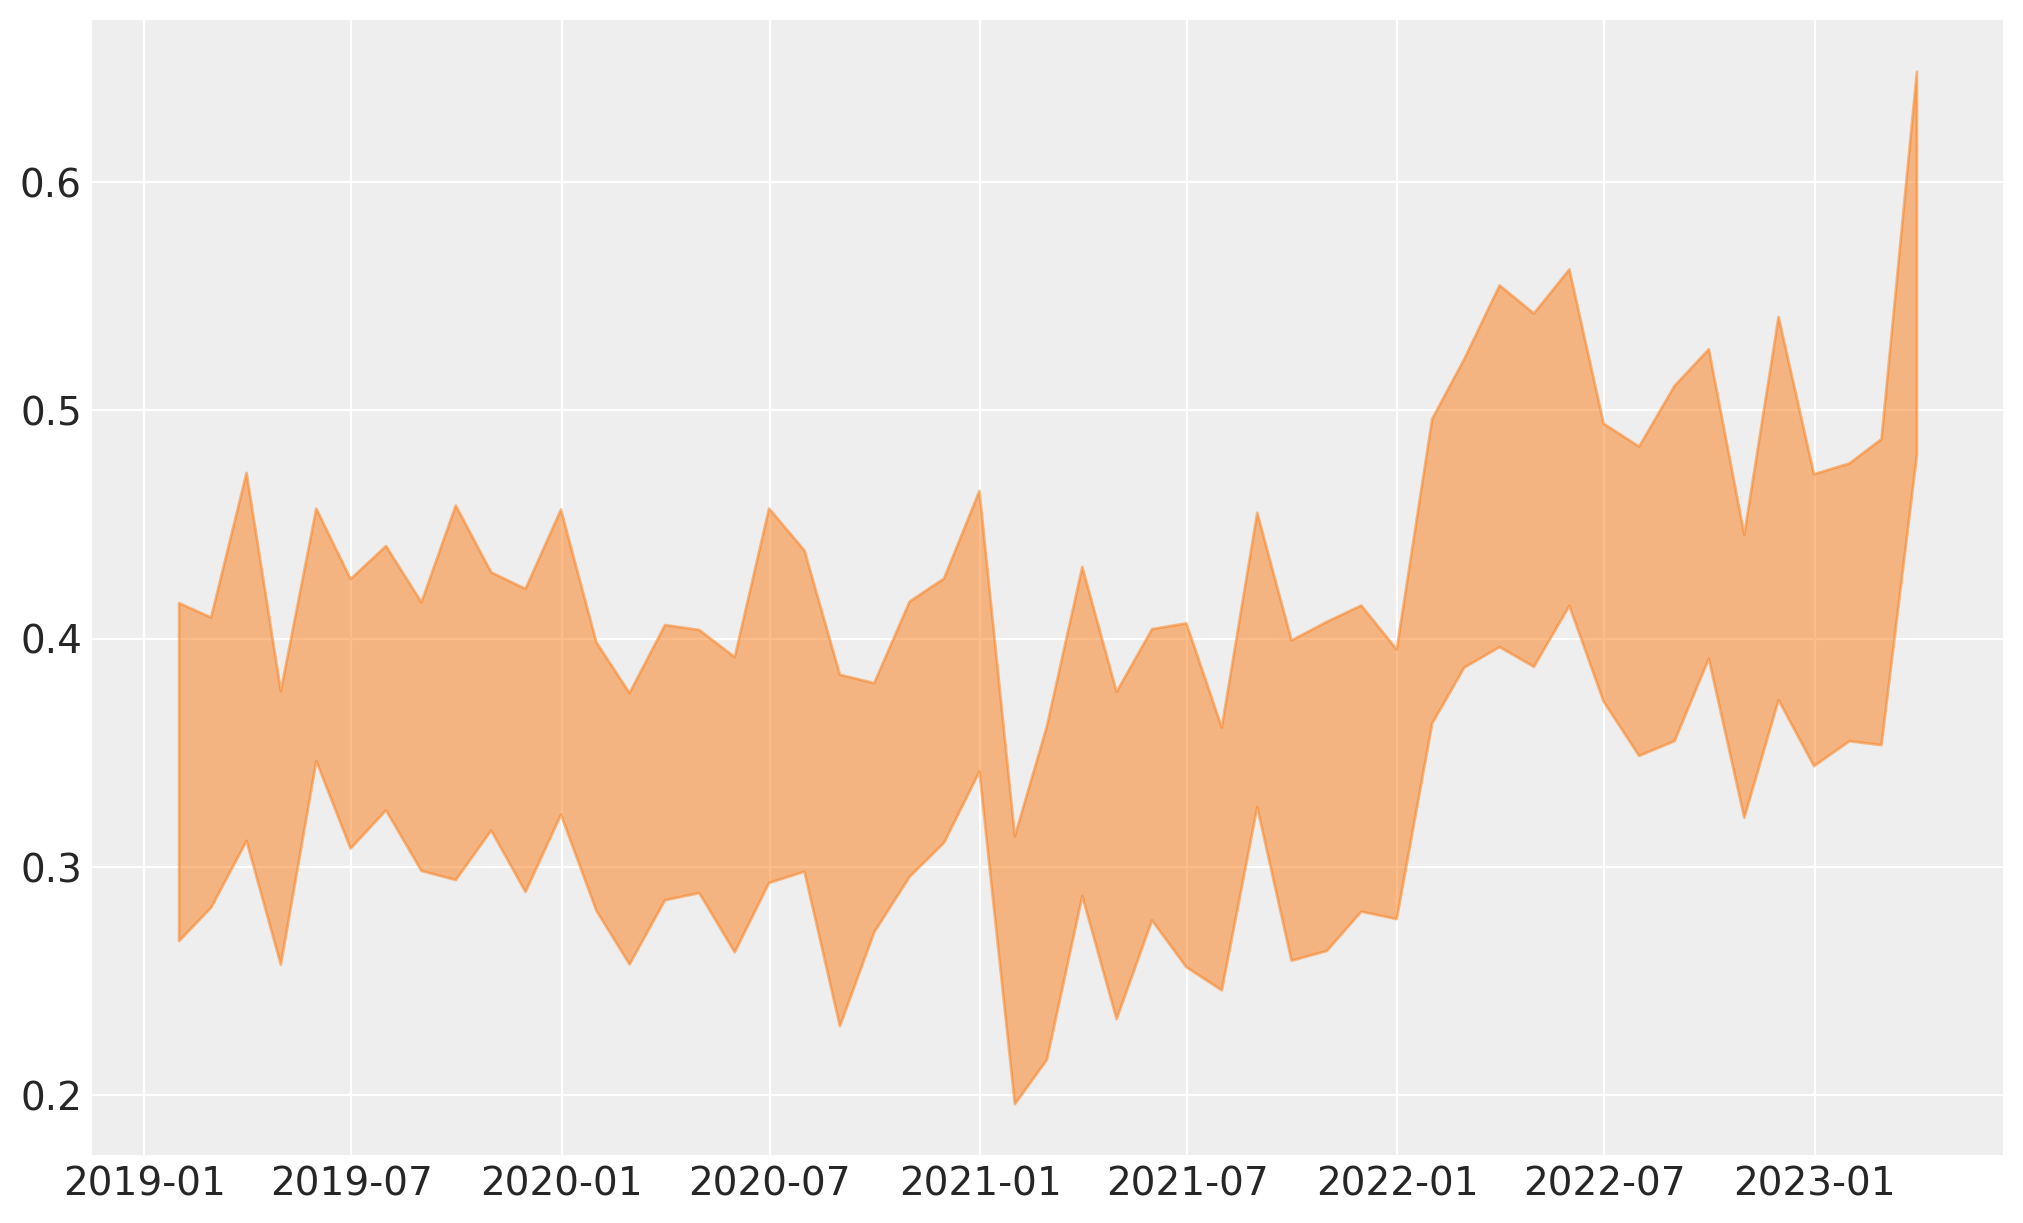

In [90]:
az.plot_hdi(date, binom_trace.posterior['p_true'], smooth=False)

In [17]:
N = 20
K = 20

alpha = 2.0
P0 = sp.stats.norm

In [18]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

x_plot = xr.DataArray(np.repeat(np.linspace(-3, 3, 50), 4)+np.random.normal(0, .1, 200), dims=["plot"])

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot.values)).sum(axis=1)

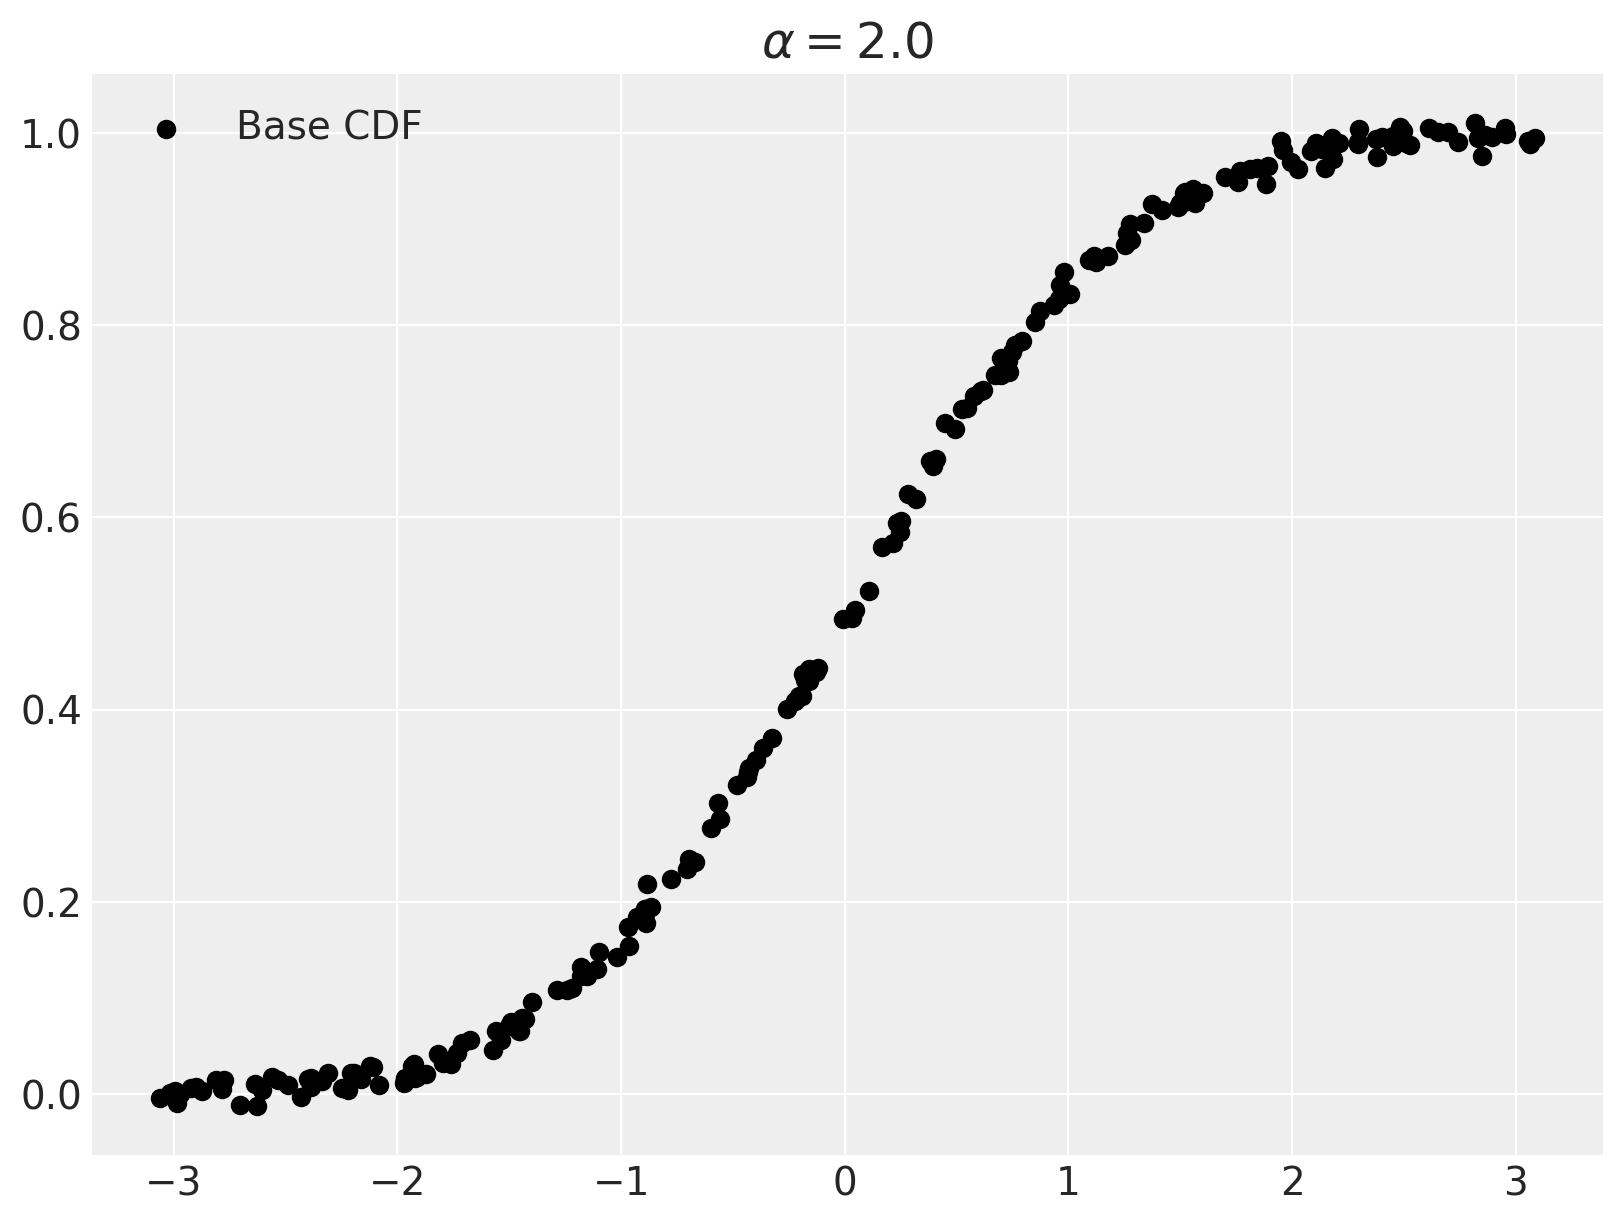

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
actual_cdf = P0.cdf(x_plot)
observed_cdf = actual_cdf + np.random.normal(0, 0.01, size=(len(actual_cdf)))
#ax.plot(x_plot, sample_cdfs[0], c="gray", alpha=0.75, label="DP sample CDFs")
#ax.plot(x_plot, sample_cdfs[1:].T, c="gray", alpha=0.75)
ax.scatter(x_plot, observed_cdf, c="k", label="Base CDF")

ax.set_title(rf"$\alpha = {alpha}$")
ax.legend(loc=2);

In [20]:
test_break_points = np.linspace(-2, 2, K)
np.greater_equal.outer(test_break_points, x_plot.values)

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [21]:
with pm.Model() as cdf:
  #alpha_break = pm.Gamma('alpha_break', 1, 1)
  alpha_sticks = pm.Gamma('alpha_sticks', 1, 1)
  start = -3
  end = 3
  
  stick_breaking_ = pm.StickBreakingWeights('sticks', alpha=alpha_sticks, K=K-1)
  #w = pm.Normal("weights", mu=0, sigma=2, shape=K, transform=pm.distributions.transforms.ordered, initval=np.linspace(-3, 3, K))
  
  sigma = pm.HalfNormal("sigma", sigma=0.01)
  samples = pm.Deterministic('w', (stick_breaking_[:,pt.newaxis]*pt.less(test_break_points[:, pt.newaxis], x_plot.values)).sum(axis=0))
  obs = pm.Normal("obs", mu=samples, sigma=sigma, observed=observed_cdf)
  
  trace = pm.sample(100_000, tune=10_000, target_accept=.99, nuts_sampler="numpyro")

  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

In [25]:
pm.summary(trace, var_names=['alpha_sticks', 'sticks'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_sticks  4.567  1.040   2.698    6.540      0.001    0.001  500680.0   
sticks[0]     0.023  0.005   0.014    0.033      0.000    0.000  368897.0   
sticks[1]     0.022  0.009   0.005    0.039      0.000    0.000  214748.0   
sticks[2]     0.024  0.009   0.006    0.041      0.000    0.000  230414.0   
sticks[3]     0.046  0.009   0.030    0.063      0.000    0.000  330418.0   
sticks[4]     0.029  0.010   0.010    0.048      0.000    0.000  281185.0   
sticks[5]     0.050  0.009   0.033    0.066      0.000    0.000  375303.0   
sticks[6]     0.069  0.009   0.053    0.085      0.000    0.000  401537.0   
sticks[7]     0.079  0.009   0.062    0.096      0.000    0.000  390262.0   
sticks[8]     0.083  0.008   0.068    0.098      0.000    0.000  440489.0   
sticks[9]     0.072  0.011   0.052    0.092      0.000    0.000  362112.0   
sticks[10]    0.083  0.011   0.061    0.104      0.000    0.000  357072.0   
sticks[11]    0.090  0.009   0.074    0.107      0.000    0.000  424378.0   
sticks[12]    0.072  0.008   0.056    0.087      0.000    0.000  402009.0   
sticks[13]    0.054  0.009   0.037    0.070      0.000    0.000  376046.0   
sticks[14]    0.056  0.009   0.039    0.074      0.000    0.000  353745.0   
sticks[15]    0.040  0.009   0.023    0.057      0.000    0.000  335243.0   
sticks[16]    0.038  0.009   0.022    0.055      0.000    0.000  337584.0   
sticks[17]    0.020  0.009   0.004    0.036      0.000    0.000  202491.0   
sticks[18]    0.015  0.008   0.000    0.029      0.000    0.000  167994.0   
sticks[19]    0.034  0.006   0.024    0.045      0.000    0.000  337244.0   

              ess_tail  r_hat  
alpha_sticks  264297.0    1.0  
sticks[0]     226261.0    1.0  
sticks[1]     132726.0    1.0  
sticks[2]     131312.0    1.0  
sticks[3]     254036.0    1.0  
sticks[4]     168172.0    1.0  
sticks[5]     251438.0    1.0  
sticks[6]     276232.0    1.0  
sticks[7]     271572.0    1.0  
sticks[8]     282496.0    1.0  
sticks[9]     262088.0    1.0  
sticks[10]    266469.0    1.0  
sticks[11]    284150.0    1.0  
sticks[12]    273918.0    1.0  
sticks[13]    251528.0    1.0  
sticks[14]    255038.0    1.0  
sticks[15]    222581.0    1.0  
sticks[16]    235468.0    1.0  
sticks[17]    118463.0    1.0  
sticks[18]    106517.0    1.0  
sticks[19]    339650.0    1.0

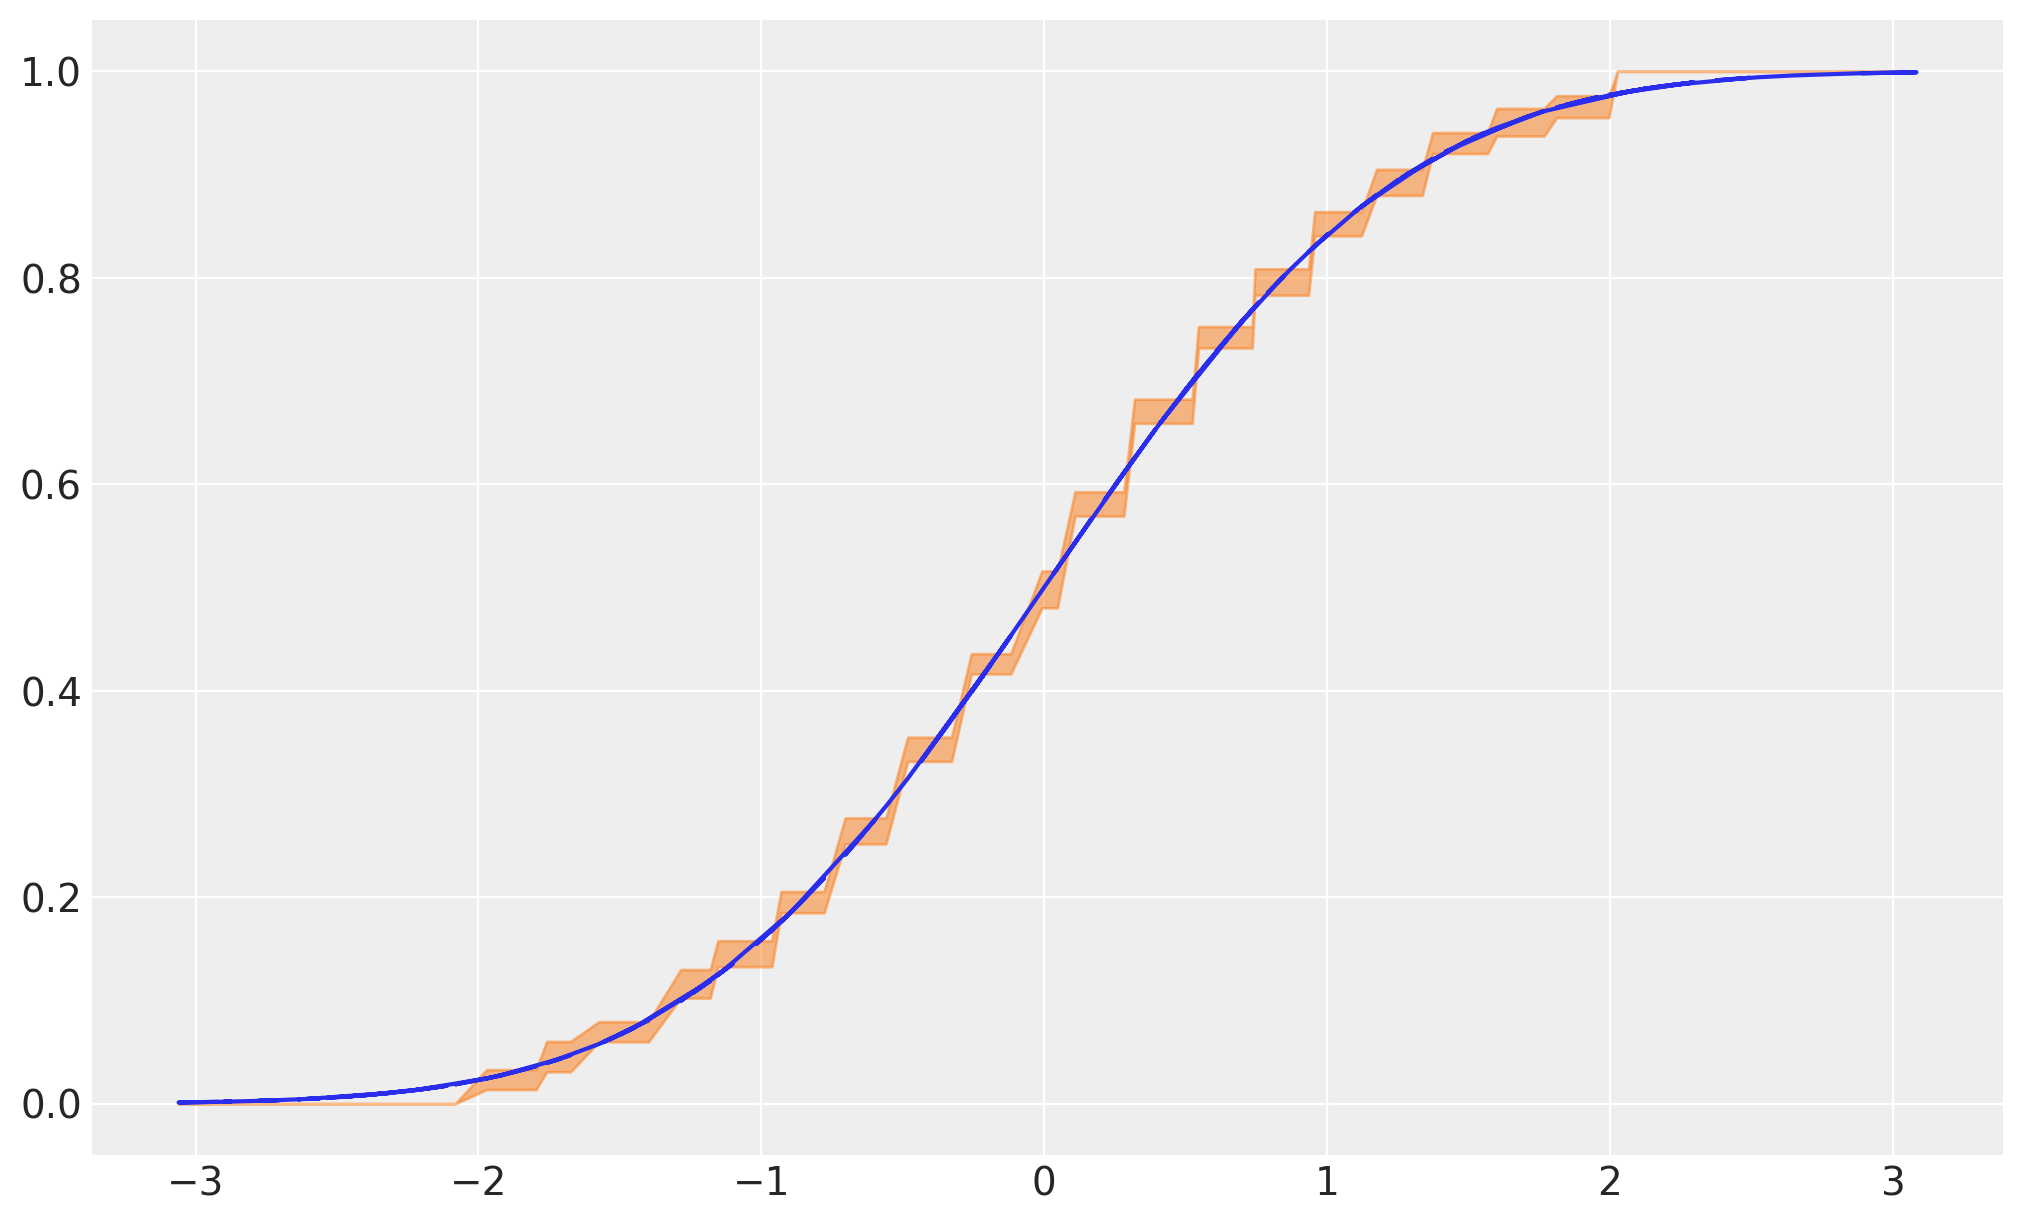

In [23]:
az.plot_hdi(x_plot.values, trace.posterior['w'], smooth=False)
plt.plot(x_plot.values, P0.cdf(x_plot))

# Latent Survival Model For Impressions
---
## Survival Model
The reaction to advertisment may not be uniform across different segments of the leading to a mixture of thresholds and saturations

In [11]:
n_obs = 156
n_media_vars = 3
n_controls = 1
multiplicative = False
X, controls, y, beta, beta_c, inter, half_sat, n = simulate_data(n_media_vars, n_controls, R2=.95, nobs=n_obs, intercept=1, multiplicative=multiplicative)

In [12]:
def r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

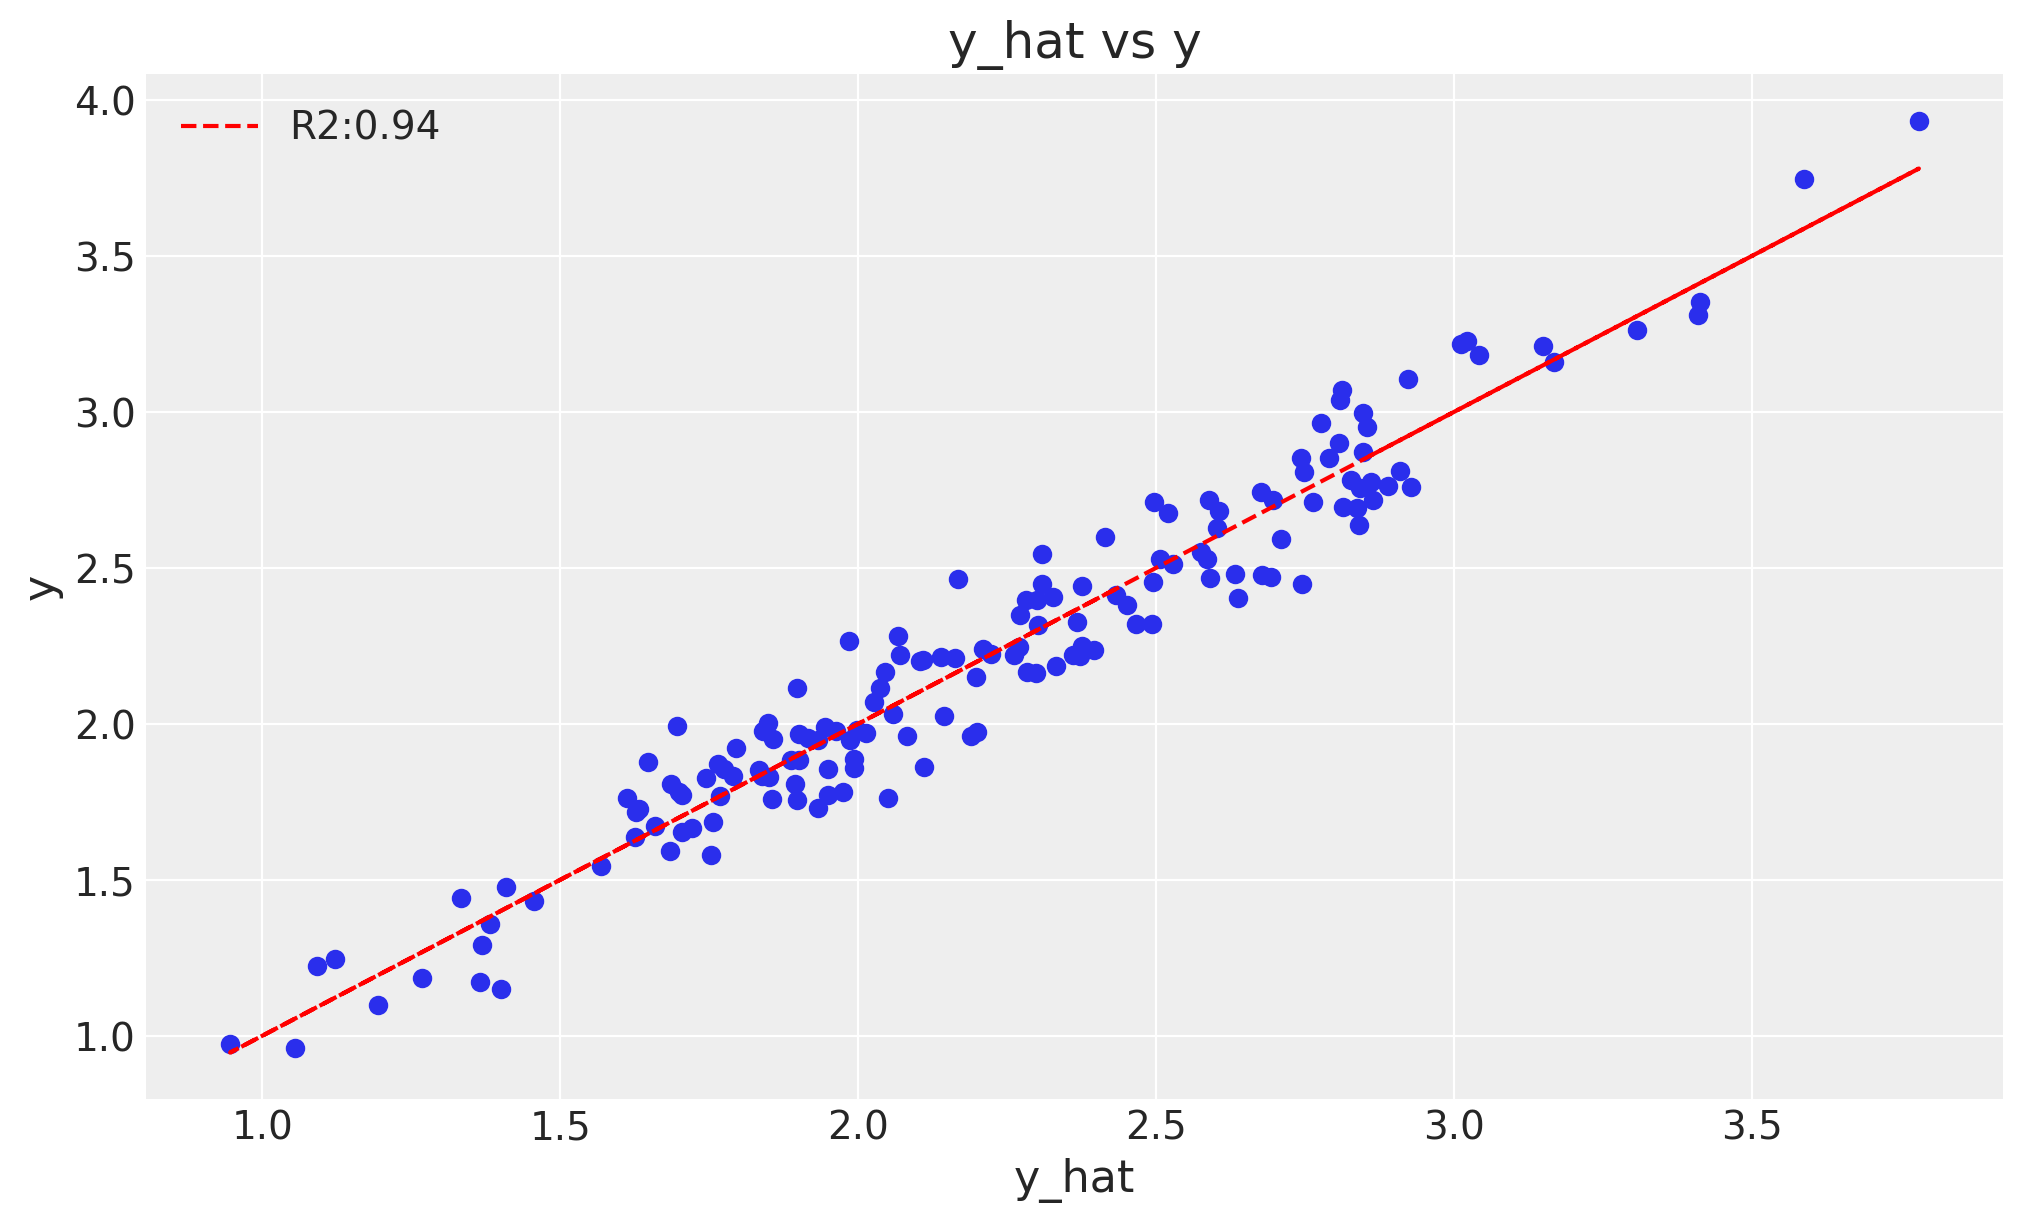

In [13]:
X_contribution = hill(X, beta, half_sat, n)
control_contribution = controls * beta_c
if multiplicative:
  y_hat = np.exp(X_contribution.sum(axis=1) + control_contribution.sum(axis=1) + inter)
else:
  y_hat = X_contribution.sum(axis=1) + control_contribution.sum(axis=1) + inter
plt.scatter(y_hat, y)
plt.plot(y_hat, y_hat, 'r--', label=f'R2:{r2(y, y_hat):.2f}')
plt.legend()
plt.title('y_hat vs y')
plt.xlabel('y_hat')
plt.ylabel('y');

In [14]:
interval_bounds = np.quantile(X, np.linspace(0, 1, 11), axis=0)#np.arange(0, X.flatten().max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.shape[0] - 1
intervals = np.arange(n_intervals)
ob = np.arange(n_obs)

In [15]:
last_period = get_last_periods(X, interval_bounds, n_intervals)
exposure = compute_exposure(X, interval_bounds, n_intervals)

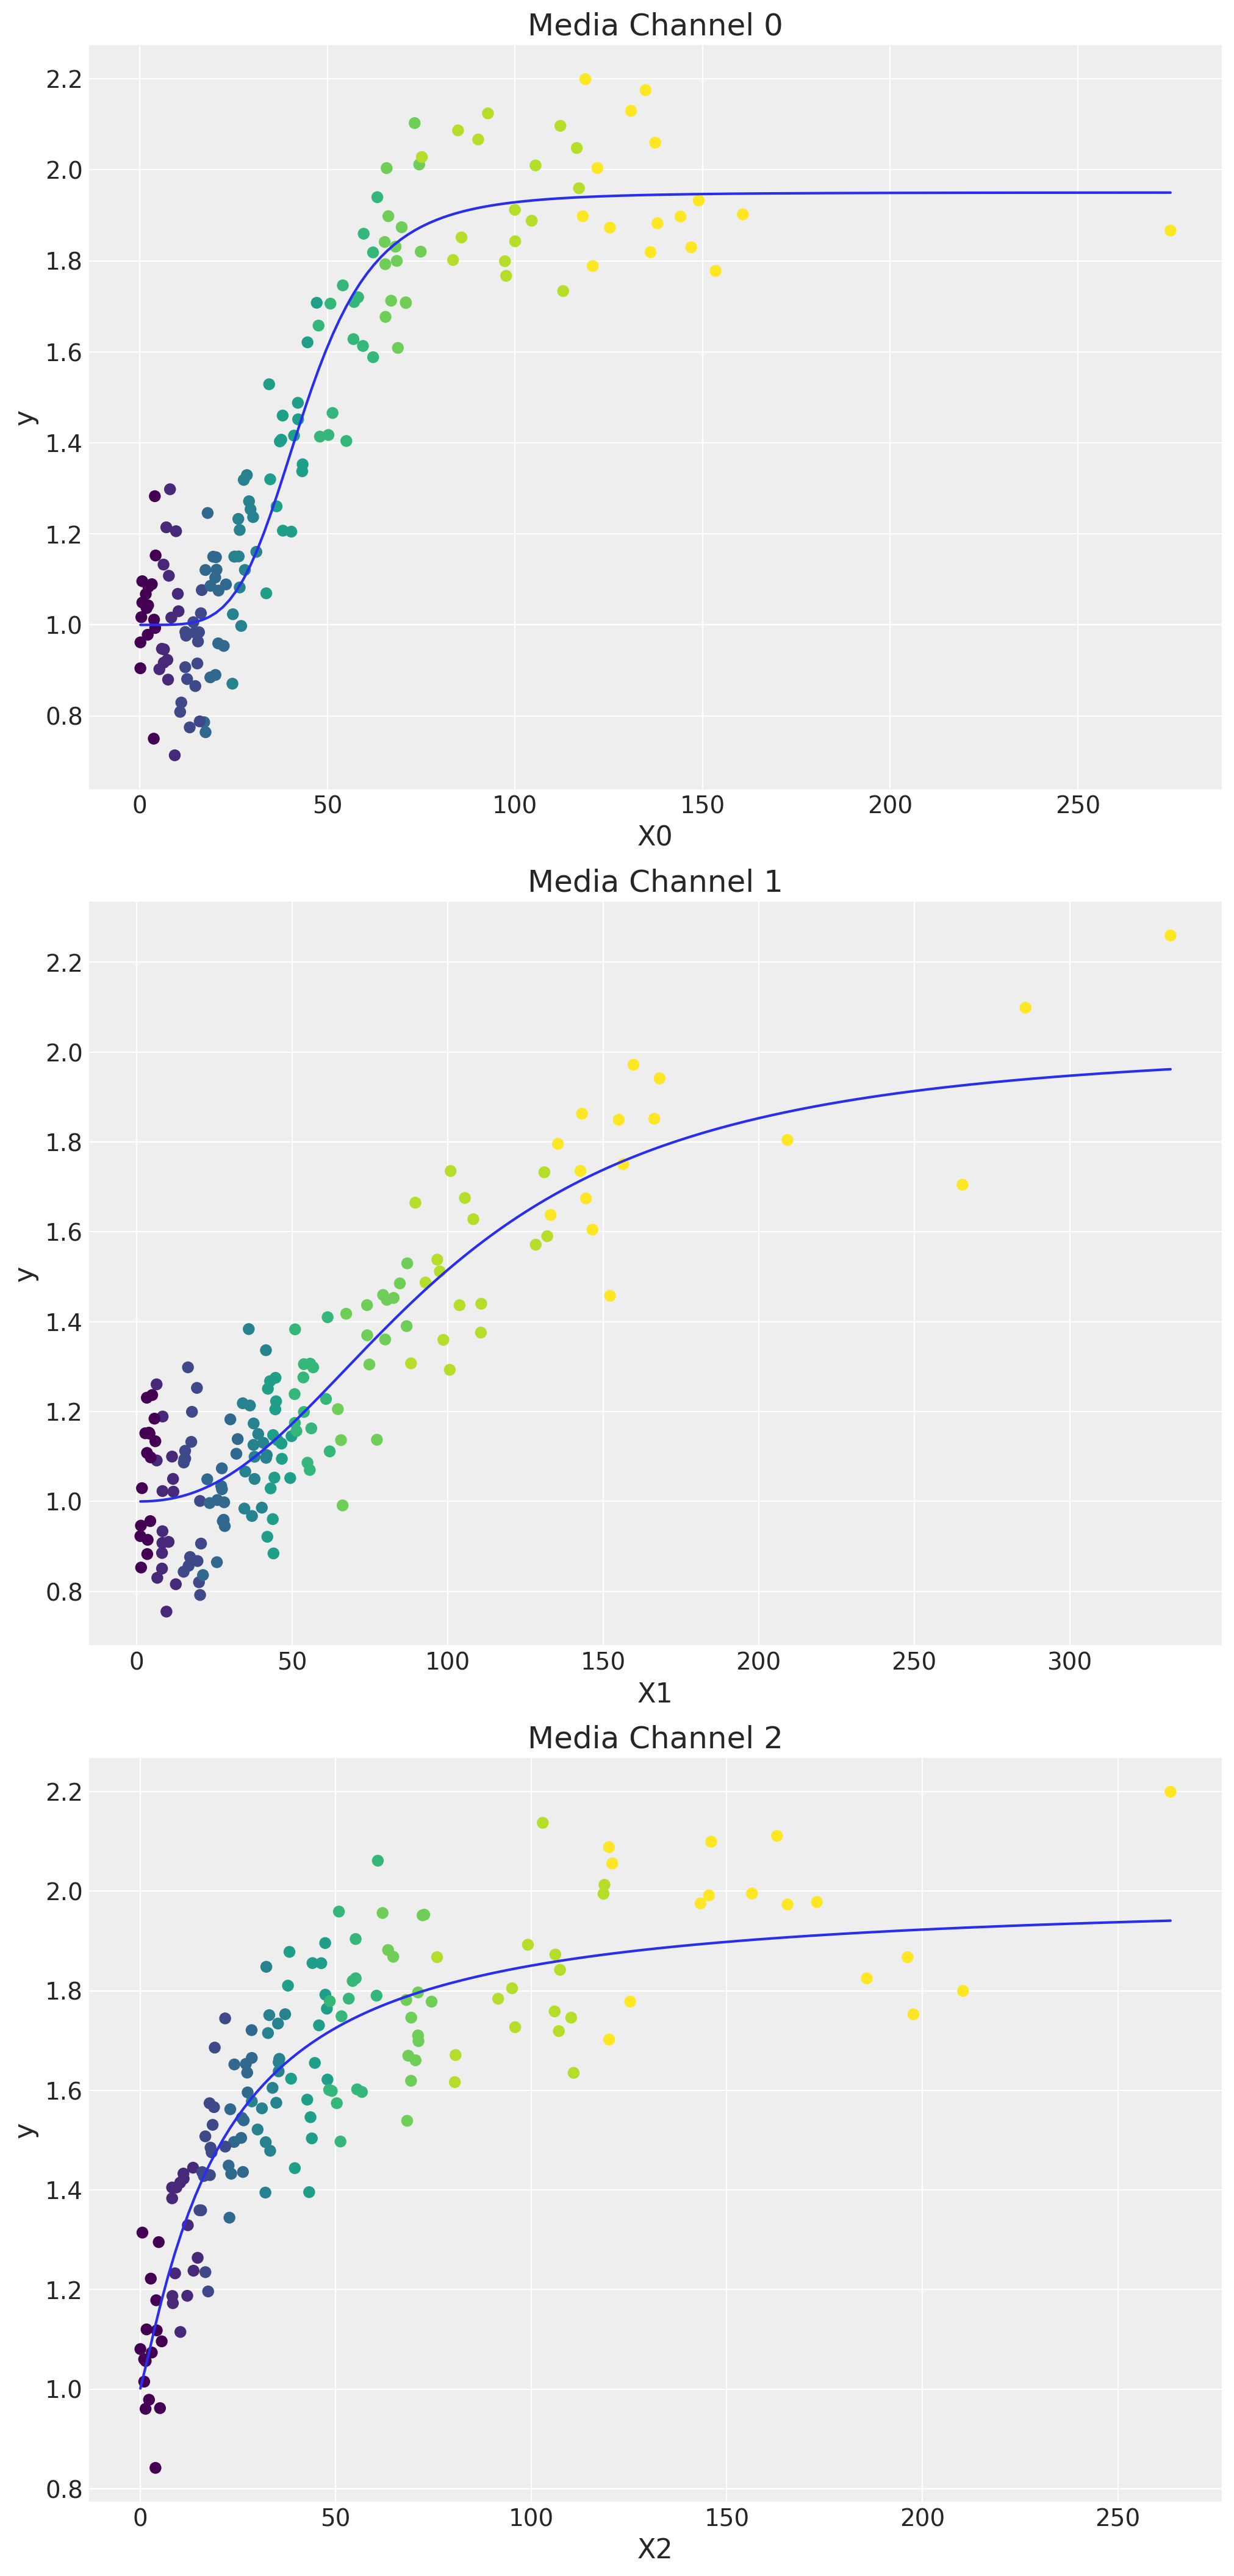

In [16]:
fig, ax = plt.subplots(n_media_vars, figsize=(10, 7*n_media_vars))
for i in range(n_media_vars):
  x_sim = np.linspace(X[:, i].min(), X[:, i].max(), 151)
  ax[i].plot(x_sim, x_sim**n[i]/(x_sim**n[i]+half_sat[i]**n[i])*beta[i] + inter)
  ax[i].set_title(f'Media Channel {i}')
  ax[i].set_xlabel(f'X{i}')
  ax[i].set_ylabel(f'y')
#plt.scatter((interval_bounds[last_period]+interval_bounds[last_period+1])/2, y, c=last_period)
  if multiplicative:
    y_ = np.log(y)
  else:
    y_ = y
  ax[i].scatter(X[:, i], X_contribution[:, i] + y_ - X_contribution.sum(axis=1)-control_contribution.sum(axis=1), c=last_period[:, i])

In [28]:
X.shape

(156, 3)

In [58]:
coords = {"media_var": [f'm_{i}' for i in range(n_media_vars)], "intervals": intervals, 
          "obs": ob, 'controls': [f'c_{i}' for i in range(n_controls)]}

with pm.Model(coords=coords) as dirichlet_survival:
  #X_data = pm.MutableData("X", X, dims=("obs", "media_var"))



  break_point = pm.Deterministic(
    "break_point", pt.stack([pm.Normal(f'break_point_{i}', 2, 5, dims=('intervals'), transform=pm.distributions.transforms.Ordered()) for i in range(n_media_vars)])
    )
  lambda0 = pm.Beta('lambda0',1, 3, dims=('media_var', 'intervals'))
  media_effect = pm.HalfNormal('media_effect', 1, dims=('media_var',))
  control_effect = pm.HalfNormal('control_effect', 1, dims=('controls',))
  offset = pm.Normal('offset', 0, 1)
  
  my_map = pm.Deterministic("map", pt.less(pt.exp(break_point), X[..., np.newaxis]), dims=('obs', 'media_var', 'intervals'))
  media_curve = pm.Deterministic("media_curve", pt.stack([(my_map[:, i,:]*stick_breaking(lambda0[i,:])).sum(axis=-1) * media_effect[i] for i in range(n_media_vars)]))
  mu = pm.Deterministic("mu", pt.sum(media_curve, axis=0) + controls @ control_effect + offset, dims=("obs",))
  sigma = pm.HalfNormal('sigma', 1)

  if multiplicative:
    pm.Normal('y', mu=mu, sigma=sigma, observed=np.log(y))
  else:
    pm.Normal('y', mu=mu, sigma=sigma, observed=y, dims=("obs",))

  trace_dirichlet = pm.sample(10000, tune=10000, target_accept=.95, nuts_sampler="numpyro")

/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Compiling...
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: divide by zero encountered in log
  vari

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Sampling time = 0:00:06.363936
Transforming variables...
Transformation time = 0:00:01.192167


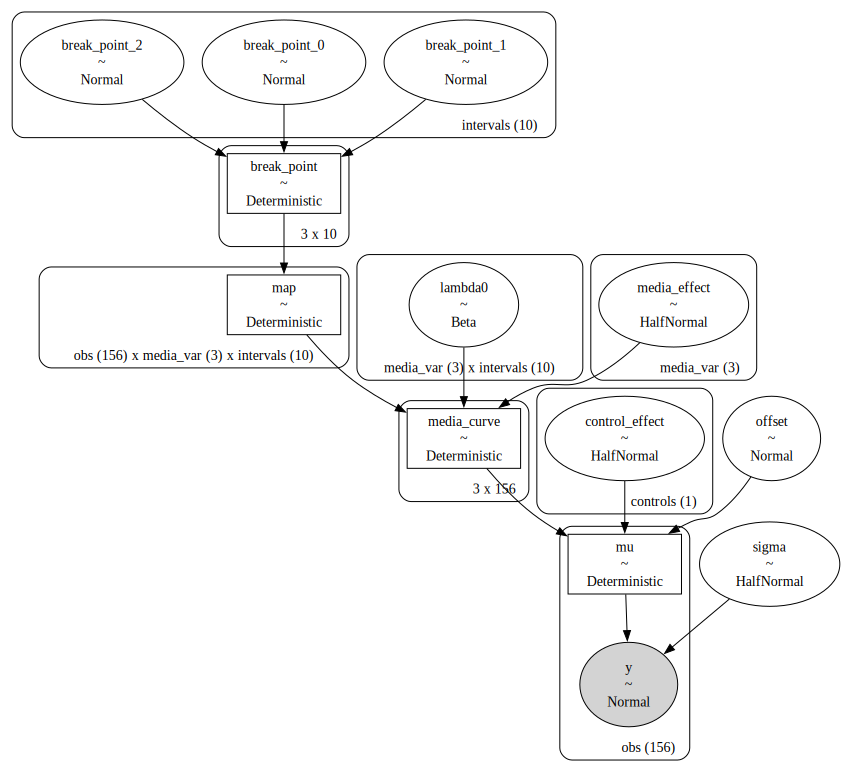

In [59]:
pm.model_to_graphviz(dirichlet_survival)


In [60]:
X[0,:]

array([70.46536365, 88.85621307, 79.88604966])

/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appea

KeyboardInterrupt: 

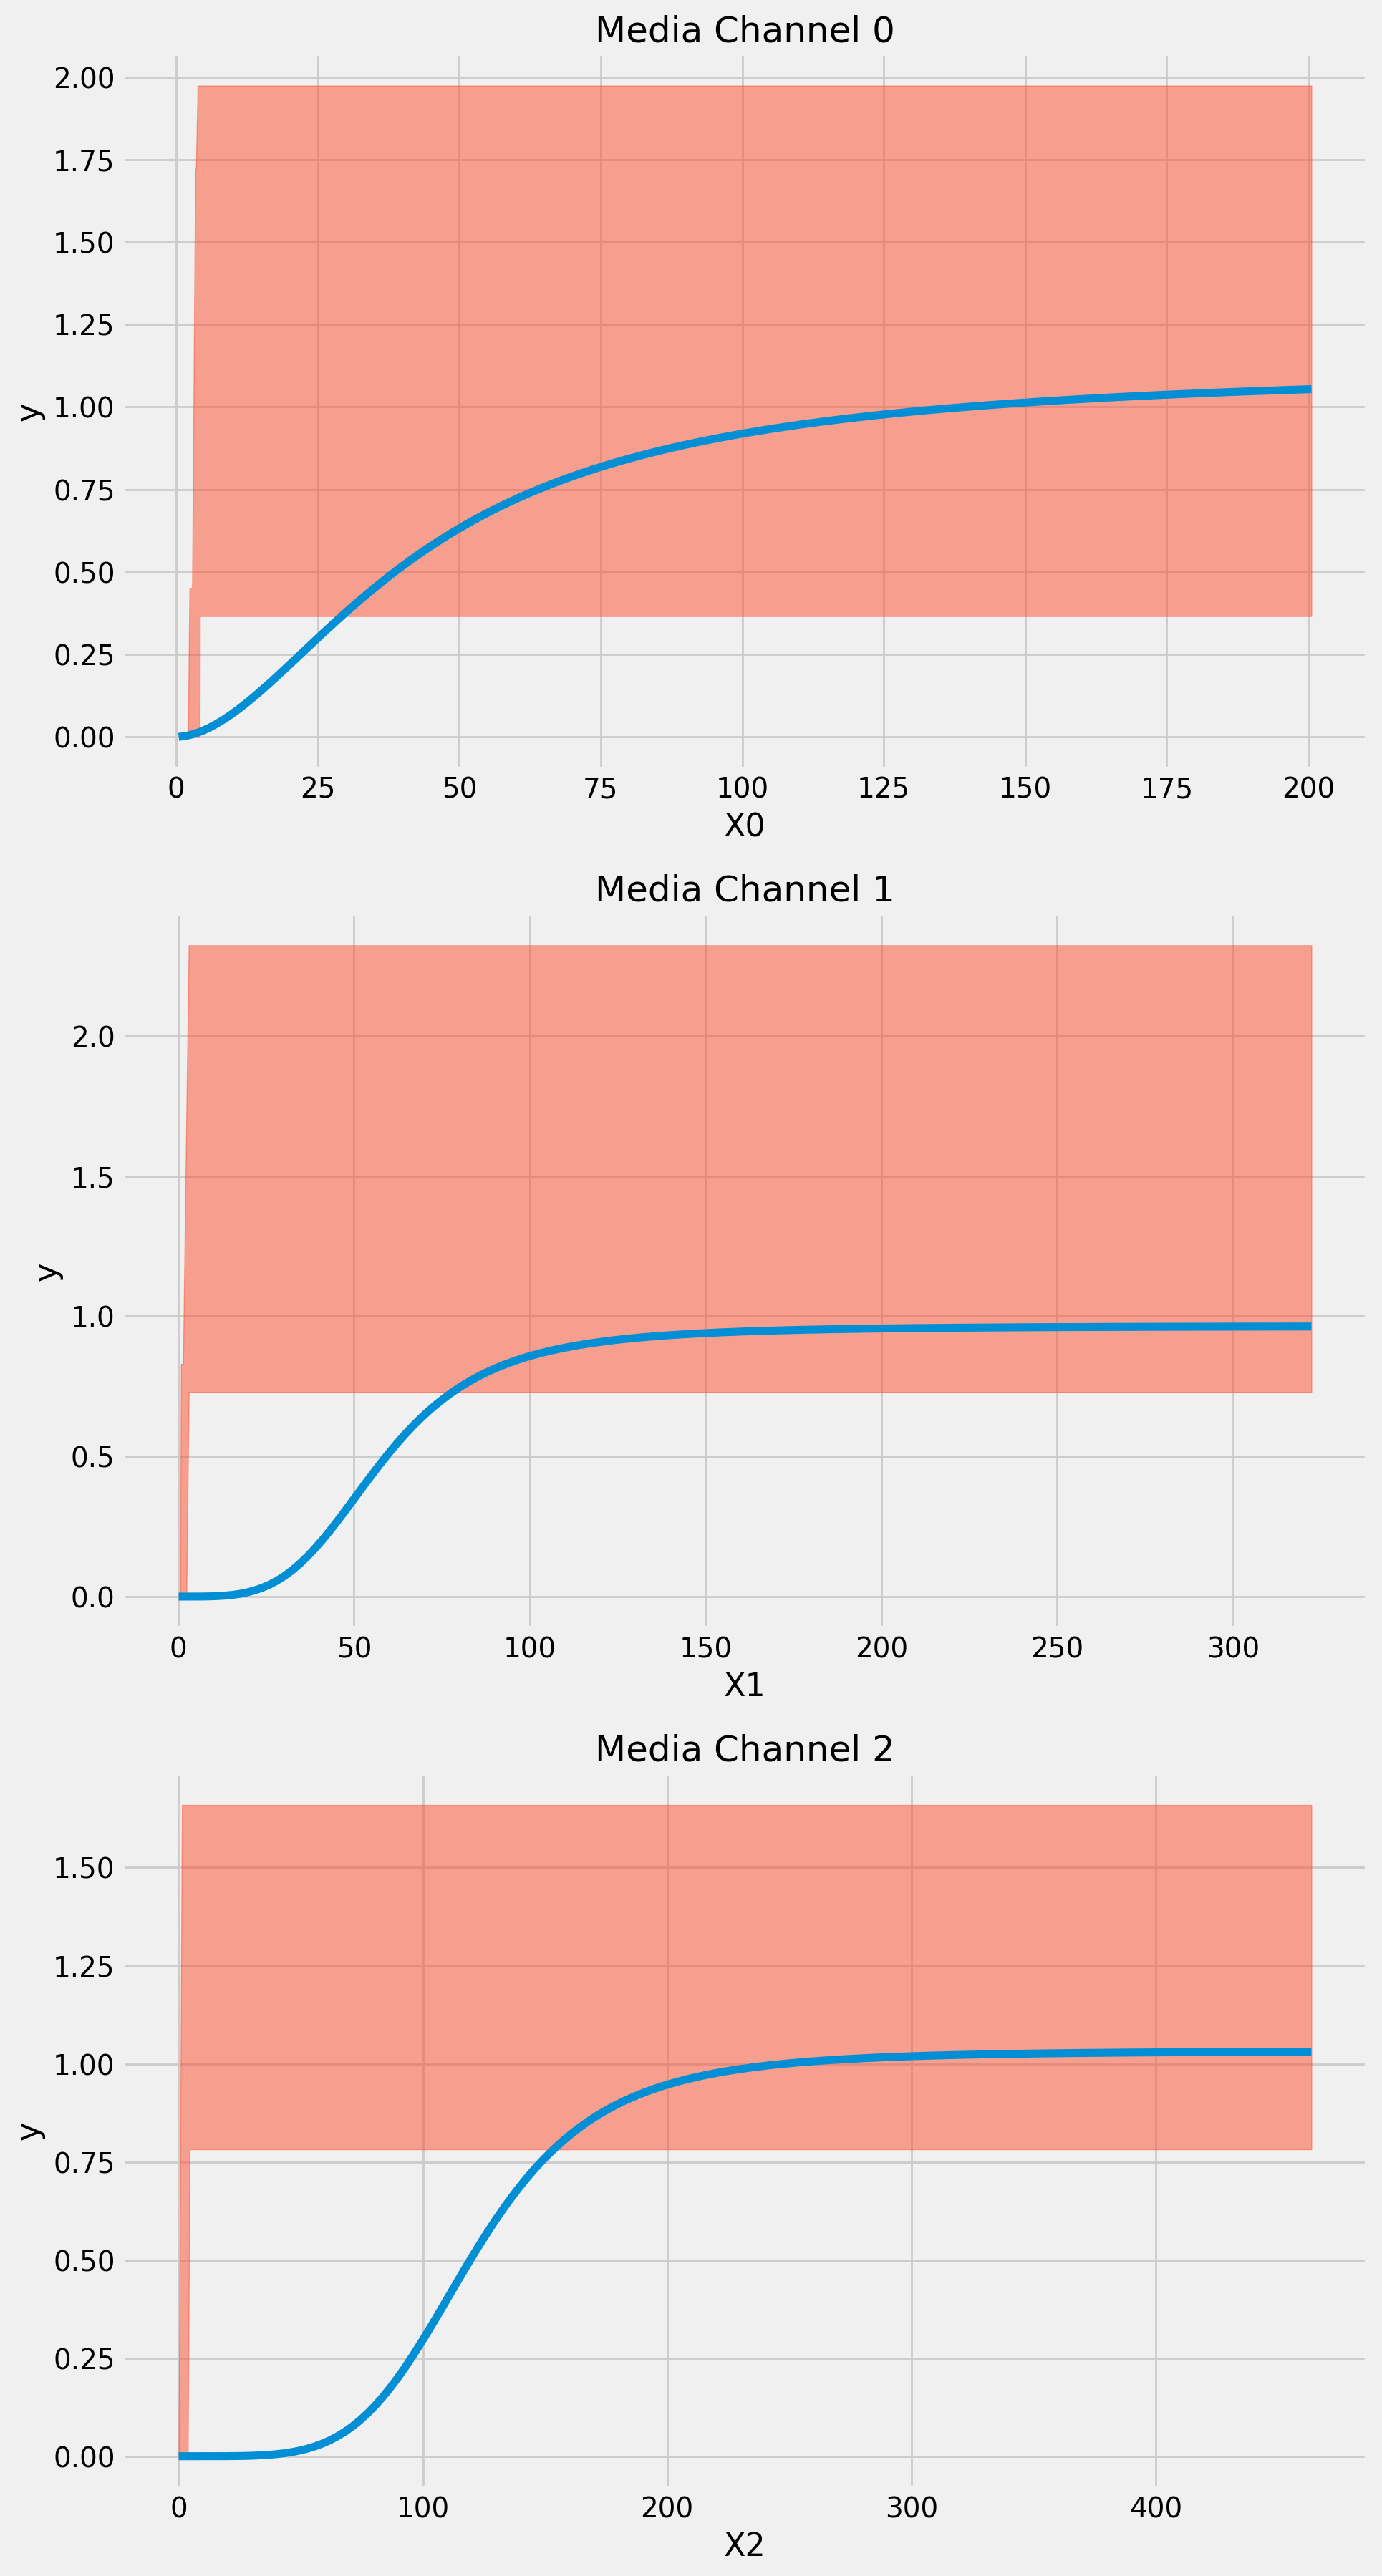

In [57]:

fig, ax = plt.subplots(n_media_vars, figsize=(10, 7*n_media_vars))
for i in range(n_media_vars):
  x_sim = np.linspace(X[:, i].min(), X[:, i].max(), 151)
  az.plot_hdi(X[:,i], trace_dirichlet.posterior['media_curve'].values[:,:, i, :], ax=ax[i], smooth=False)
  ax[i].plot(x_sim, x_sim**n[i]/(x_sim**n[i]+half_sat[i]**n[i])*beta[i])
  ax[i].set_title(f'Media Channel {i}')
  ax[i].set_xlabel(f'X{i}')
  ax[i].set_ylabel(f'y')

In [50]:
pm.summary(trace_dirichlet, var_names=['lambda0'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda0[m_0, 0]  0.312  0.137   0.159    0.457      0.068    0.052       4.0   
lambda0[m_0, 1]  0.360  0.073   0.263    0.438      0.036    0.028       4.0   
lambda0[m_0, 2]  0.176  0.038   0.121    0.228      0.019    0.015       4.0   
lambda0[m_0, 3]  0.219  0.118   0.123    0.420      0.059    0.045       4.0   
lambda0[m_0, 4]  0.262  0.112   0.131    0.434      0.056    0.043       4.0   
lambda0[m_0, 5]  0.228  0.097   0.113    0.359      0.048    0.037       4.0   
lambda0[m_0, 6]  0.229  0.070   0.139    0.317      0.035    0.027       4.0   
lambda0[m_0, 7]  0.325  0.123   0.141    0.441      0.062    0.047       4.0   
lambda0[m_0, 8]  0.225  0.086   0.144    0.369      0.043    0.033       4.0   
lambda0[m_0, 9]  0.334  0.106   0.187    0.458      0.053    0.041       4.0   
lambda0[m_1, 0]  0.313  0.109   0.134    0.408      0.055    0.042       4.0   
lambda0[m_1, 1]  0.213  0.033   0.157    0.239      0.016    0.013       4.0   
lambda0[m_1, 2]  0.194  0.065   0.129    0.282      0.033    0.025       4.0   
lambda0[m_1, 3]  0.332  0.079   0.255    0.462      0.039    0.030       4.0   
lambda0[m_1, 4]  0.287  0.133   0.114    0.467      0.066    0.051       4.0   
lambda0[m_1, 5]  0.253  0.105   0.117    0.410      0.052    0.040       4.0   
lambda0[m_1, 6]  0.234  0.098   0.128    0.359      0.049    0.038       4.0   
lambda0[m_1, 7]  0.233  0.117   0.115    0.429      0.059    0.045       4.0   
lambda0[m_1, 8]  0.347  0.117   0.183    0.464      0.059    0.045       4.0   
lambda0[m_1, 9]  0.257  0.108   0.142    0.423      0.054    0.041       4.0   
lambda0[m_2, 0]  0.232  0.073   0.165    0.354      0.037    0.028       4.0   
lambda0[m_2, 1]  0.326  0.091   0.201    0.456      0.045    0.035       4.0   
lambda0[m_2, 2]  0.260  0.091   0.129    0.386      0.045    0.035       4.0   
lambda0[m_2, 3]  0.255  0.128   0.116    0.452      0.064    0.049       4.0   
lambda0[m_2, 4]  0.280  0.086   0.161    0.365      0.043    0.033       4.0   
lambda0[m_2, 5]  0.264  0.078   0.171    0.378      0.039    0.030       4.0   
lambda0[m_2, 6]  0.304  0.111   0.126    0.420      0.055    0.042       4.0   
lambda0[m_2, 7]  0.232  0.047   0.183    0.307      0.023    0.018       4.0   
lambda0[m_2, 8]  0.275  0.124   0.119    0.406      0.062    0.048       4.0   
lambda0[m_2, 9]  0.201  0.106   0.112    0.379      0.053    0.040       4.0   

                 ess_tail         r_hat  
lambda0[m_0, 0]       4.0  5.343976e+15  
lambda0[m_0, 1]       4.0  5.556107e+15  
lambda0[m_0, 2]       4.0  5.343976e+15  
lambda0[m_0, 3]       4.0  5.556107e+15  
lambda0[m_0, 4]       4.0  5.343976e+15  
lambda0[m_0, 5]       4.0  5.343976e+15  
lambda0[m_0, 6]       4.0  5.556107e+15  
lambda0[m_0, 7]       4.0  5.556107e+15  
lambda0[m_0, 8]       4.0  5.343976e+15  
lambda0[m_0, 9]       4.0  5.343976e+15  
lambda0[m_1, 0]       4.0  5.343976e+15  
lambda0[m_1, 1]       4.0  5.343976e+15  
lambda0[m_1, 2]       4.0  5.343976e+15  
lambda0[m_1, 3]       4.0  5.556107e+15  
lambda0[m_1, 4]       4.0  5.343976e+15  
lambda0[m_1, 5]       4.0  5.343976e+15  
lambda0[m_1, 6]       4.0  5.343976e+15  
lambda0[m_1, 7]       4.0  5.343976e+15  
lambda0[m_1, 8]       4.0  5.343976e+15  
lambda0[m_1, 9]       4.0  5.343976e+15  
lambda0[m_2, 0]       4.0  5.343976e+15  
lambda0[m_2, 1]       4.0  5.343976e+15  
lambda0[m_2, 2]       4.0  5.556107e+15  
lambda0[m_2, 3]       4.0  5.343976e+15  
lambda0[m_2, 4]       4.0  5.343976e+15  
lambda0[m_2, 5]       4.0  5.343976e+15  
lambda0[m_2, 6]       4.0  5.556107e+15  
lambda0[m_2, 7]       4.0  5.343976e+15  
lambda0[m_2, 8]       4.0  5.556107e+15  
lambda0[m_2, 9]       4.0  5.556107e+15

In [34]:
coords = {"media_var": [f'm_{i}' for i in range(n_media_vars)], "intervals": intervals, 
          "obs": ob, 'controls': [f'c_{i}' for i in range(n_controls)]}

with pm.Model(coords=coords) as model_survival:
    lambda0 = pm.Exponential("lambda0", 1, dims=("media_var", "intervals"))
    betas = pm.Normal("betas", 0, 1, dims=("controls",))
    
    sigma = pm.HalfCauchy("sigma", .1)
    offset = pm.Normal("offset", 0, 3)
    mu = pm.Deterministic("mu", pt.sum(exposure * lambda0, axis=(1, -1)) + controls @ betas + offset, dims=("obs",))
    
    obs = pm.Normal("y", mu, sigma, observed=np.log(y) if multiplicative else y, dims='obs')
    trace = pm.sample(1000, tune=1000, target_accept=.99)
    pm.compute_log_likelihood(trace)
    posterior_suvival_predictive = pm.sample_posterior_predictive(trace, var_names=["mu", "y"])
pm.summary(trace, var_names=["lambda0", "sigma", 'offset', 'betas'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, betas, sigma, offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Sampling: [y]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda0[m_0, 0]  0.029  0.021   0.000    0.067      0.000    0.000    1998.0   
lambda0[m_0, 1]  0.023  0.016   0.000    0.050      0.000    0.000    2104.0   
lambda0[m_0, 2]  0.017  0.012   0.000    0.039      0.000    0.000    2729.0   
lambda0[m_0, 3]  0.010  0.008   0.000    0.024      0.000    0.000    2901.0   
lambda0[m_0, 4]  0.014  0.011   0.000    0.033      0.000    0.000    1463.0   
lambda0[m_0, 5]  0.015  0.010   0.000    0.033      0.000    0.000    2822.0   
lambda0[m_0, 6]  0.011  0.007   0.000    0.023      0.000    0.000    2178.0   
lambda0[m_0, 7]  0.011  0.006   0.000    0.020      0.000    0.000    1795.0   
lambda0[m_0, 8]  0.007  0.005   0.000    0.016      0.000    0.000    2029.0   
lambda0[m_0, 9]  0.004  0.001   0.001    0.006      0.000    0.000    3021.0   
lambda0[m_1, 0]  0.006  0.006   0.000    0.016      0.000    0.000    3740.0   
lambda0[m_1, 1]  0.006  0.005   0.000    0.015      0.000    0.000    3470.0   
lambda0[m_1, 2]  0.003  0.003   0.000    0.008      0.000    0.000    3502.0   
lambda0[m_1, 3]  0.005  0.004   0.000    0.012      0.000    0.000    2566.0   
lambda0[m_1, 4]  0.008  0.006   0.000    0.018      0.000    0.000    1673.0   
lambda0[m_1, 5]  0.022  0.006   0.011    0.034      0.000    0.000    2007.0   
lambda0[m_1, 6]  0.011  0.006   0.000    0.022      0.000    0.000    1993.0   
lambda0[m_1, 7]  0.005  0.004   0.000    0.012      0.000    0.000    2227.0   
lambda0[m_1, 8]  0.006  0.003   0.001    0.010      0.000    0.000    1624.0   
lambda0[m_1, 9]  0.001  0.001   0.000    0.002      0.000    0.000    2752.0   
lambda0[m_2, 0]  0.012  0.010   0.000    0.029      0.000    0.000    2916.0   
lambda0[m_2, 1]  0.004  0.003   0.000    0.010      0.000    0.000    3434.0   
lambda0[m_2, 2]  0.006  0.005   0.000    0.015      0.000    0.000    3290.0   
lambda0[m_2, 3]  0.007  0.005   0.000    0.016      0.000    0.000    2594.0   
lambda0[m_2, 4]  0.003  0.003   0.000    0.007      0.000    0.000    3931.0   
lambda0[m_2, 5]  0.002  0.002   0.000    0.005      0.000    0.000    3980.0   
lambda0[m_2, 6]  0.003  0.002   0.000    0.007      0.000    0.000    2523.0   
lambda0[m_2, 7]  0.010  0.003   0.004    0.016      0.000    0.000    1893.0   
lambda0[m_2, 8]  0.008  0.002   0.003    0.012      0.000    0.000    1988.0   
lambda0[m_2, 9]  0.001  0.001   0.000    0.003      0.000    0.000    2436.0   
sigma            0.266  0.017   0.235    0.296      0.000    0.000    3427.0   
offset           0.525  0.124   0.305    0.753      0.002    0.002    2714.0   
betas[c_0]      -0.887  0.022  -0.930   -0.846      0.000    0.000    3981.0   

                 ess_tail  r_hat  
lambda0[m_0, 0]    1567.0    1.0  
lambda0[m_0, 1]    1361.0    1.0  
lambda0[m_0, 2]    1880.0    1.0  
lambda0[m_0, 3]    1828.0    1.0  
lambda0[m_0, 4]     795.0    1.0  
lambda0[m_0, 5]    1426.0    1.0  
lambda0[m_0, 6]    1550.0    1.0  
lambda0[m_0, 7]    1114.0    1.0  
lambda0[m_0, 8]     999.0    1.0  
lambda0[m_0, 9]    1800.0    1.0  
lambda0[m_1, 0]    2320.0    1.0  
lambda0[m_1, 1]    2039.0    1.0  
lambda0[m_1, 2]    2063.0    1.0  
lambda0[m_1, 3]    1923.0    1.0  
lambda0[m_1, 4]    1244.0    1.0  
lambda0[m_1, 5]    1549.0    1.0  
lambda0[m_1, 6]    1456.0    1.0  
lambda0[m_1, 7]    2096.0    1.0  
lambda0[m_1, 8]     781.0    1.0  
lambda0[m_1, 9]    1983.0    1.0  
lambda0[m_2, 0]    2017.0    1.0  
lambda0[m_2, 1]    2027.0    1.0  
lambda0[m_2, 2]    2210.0    1.0  
lambda0[m_2, 3]    1471.0    1.0  
lambda0[m_2, 4]    2235.0    1.0  
lambda0[m_2, 5]    1760.0    1.0  
lambda0[m_2, 6]    1569.0    1.0  
lambda0[m_2, 7]    1585.0    1.0  
lambda0[m_2, 8]    1493.0    1.0  
lambda0[m_2, 9]    1465.0    1.0  
sigma              2623.0    1.0  
offset             2568.0    1.0  
betas[c_0]         2633.0    1.0

In [35]:
coords = {"media_var": [f'm_{i}' for i in range(n_media_vars)],
          "obs": ob, 'controls': [f'c_{i}' for i in range(n_controls)]}

with pm.Model(coords=coords) as model_parametric:
    half_sat_ = pm.HalfCauchy("half_sat", 10, dims=("media_var",))
    n_ = pm.Exponential("n", 1, dims=("media_var",))
    betas_m = pm.HalfNormal("betas_media", 3, dims=("media_var",))
    betas_c = pm.Normal("betas_control", 0, 1, dims=("controls",))
    media_transformed = pm.Deterministic("media_transformed", hill(X, 1, half_sat_, n_), dims=("obs", "media_var"))
    #media_transformed = pm.Deterministic("media_transformed", X**n_/(X**n_ + half_sat_**n_), dims=("obs", "media_var"))
    
    sigma = pm.HalfCauchy("sigma", .1)
    offset = pm.Normal("offset", 0, 3)
    mu = pm.Deterministic("mu", media_transformed @ betas_m + controls @ betas_c + offset, dims=("obs",))
    obs = pm.Normal("y", mu, sigma, observed=np.log(y) if multiplicative else y, dims='obs')
    trace_para = pm.sample(1000, tune=1000, target_accept=.99)
    pm.compute_log_likelihood(trace_para)
    posterior_para_predictive = pm.sample_posterior_predictive(trace_para, var_names=["mu", "y"])
pm.summary(trace_para, var_names=["half_sat", "n", 'offset', 'betas_media', 'betas_control'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [half_sat, n, betas_media, betas_control, sigma, offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Sampling: [y]


mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
half_sat[m_0]       104.550  167.199  24.343  230.427      5.816    4.114   
half_sat[m_1]        57.283    4.470  49.441   66.037      0.093    0.066   
half_sat[m_2]       130.668   23.582  99.615  168.973      0.772    0.546   
n[m_0]                1.088    0.343   0.512    1.707      0.010    0.007   
n[m_1]                3.718    0.767   2.387    5.194      0.016    0.012   
n[m_2]                3.351    1.072   1.536    5.384      0.027    0.019   
offset                0.727    0.133   0.458    0.948      0.004    0.003   
betas_media[m_0]      1.993    0.786   0.952    3.321      0.028    0.020   
betas_media[m_1]      1.079    0.091   0.914    1.252      0.002    0.001   
betas_media[m_2]      1.248    0.248   0.841    1.690      0.008    0.006   
betas_control[c_0]   -0.890    0.022  -0.931   -0.848      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
half_sat[m_0]         1219.0    1117.0    1.0  
half_sat[m_1]         2359.0    2401.0    1.0  
half_sat[m_2]         1205.0    1104.0    1.0  
n[m_0]                1084.0    1286.0    1.0  
n[m_1]                2397.0    2408.0    1.0  
n[m_2]                1348.0    1538.0    1.0  
offset                1497.0    1517.0    1.0  
betas_media[m_0]      1025.0    1117.0    1.0  
betas_media[m_1]      2207.0    2298.0    1.0  
betas_media[m_2]      1249.0    1144.0    1.0  
betas_control[c_0]    4095.0    2257.0    1.0

In [36]:
coords = {"media_var": [f'm_{i}' for i in range(n_media_vars)],
          "obs": ob, 'controls': [f'c_{i}' for i in range(n_controls)]}

with pm.Model(coords=coords) as model_parametric_false:
    alpha = pm.Beta("alpha", 5, 1, dims=("media_var",))
    beta_ = pm.Beta("beta", .5, .5, dims=("media_var",))
    scale = pm.HalfCauchy("scale", 1, dims=("media_var",))
    betas_m = pm.HalfNormal("betas_media", 3, dims=("media_var",))
    betas_c = pm.Normal("betas_control", 0, 1, dims=("controls",))
    media_transformed = pm.Deterministic("media_transformed", s_origin(X, 1, alpha, 10.0**(-beta_*10), scale), dims=("obs", "media_var"))
    #media_transformed = pm.Deterministic("media_transformed", X**n_/(X**n_ + half_sat_**n_), dims=("obs", "media_var"))
    
    sigma = pm.HalfCauchy("sigma", .1)
    offset = pm.Normal("offset", 0, 3)
    mu = pm.Deterministic("mu", media_transformed @ betas_m + controls @ betas_c + offset, dims=("obs",))
    obs = pm.Normal("y", mu, sigma, observed=np.log(y) if multiplicative else y, dims='obs')
    trace_para_false = pm.sample(2000, tune=2000, target_accept=.99)
    pm.compute_log_likelihood(trace_para_false)
    posterior_para_false_predictive = pm.sample_posterior_predictive(trace_para_false, var_names=["mu", "y"])
pm.summary(trace_para_false, var_names=["alpha", "beta", 'scale', 'offset', 'betas_media', 'betas_control'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, scale, betas_media, betas_control, sigma, offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 598 seconds.


Sampling: [y]


mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha[m_0]            0.970    0.059   0.868    1.000      0.001    0.001   
alpha[m_1]            0.967    0.061   0.857    1.000      0.001    0.001   
alpha[m_2]            0.970    0.062   0.863    1.000      0.001    0.001   
beta[m_0]             0.051    0.040   0.007    0.118      0.001    0.000   
beta[m_1]             0.745    0.203   0.398    1.000      0.003    0.002   
beta[m_2]             0.745    0.233   0.304    1.000      0.003    0.002   
scale[m_0]          144.445  326.407   0.051  629.974      4.206    2.974   
scale[m_1]           65.116  133.981   0.058  273.263      1.882    1.331   
scale[m_2]          129.103  301.816   0.030  559.955      4.089    2.891   
offset                0.838    0.066   0.715    0.961      0.001    0.001   
betas_media[m_0]      2.529    1.354   0.891    5.135      0.021    0.015   
betas_media[m_1]      1.008    0.064   0.886    1.125      0.001    0.001   
betas_media[m_2]      1.077    0.117   0.873    1.280      0.002    0.001   
betas_control[c_0]   -0.889    0.021  -0.929   -0.849      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
alpha[m_0]            4701.0    6253.0    1.0  
alpha[m_1]            4403.0    6277.0    1.0  
alpha[m_2]            4661.0    6153.0    1.0  
beta[m_0]             4206.0    5545.0    1.0  
beta[m_1]             3808.0    2698.0    1.0  
beta[m_2]             3621.0    2637.0    1.0  
scale[m_0]            4684.0    6494.0    1.0  
scale[m_1]            4418.0    5851.0    1.0  
scale[m_2]            4666.0    5866.0    1.0  
offset                5827.0    5540.0    1.0  
betas_media[m_0]      4252.0    5954.0    1.0  
betas_media[m_1]      7686.0    5029.0    1.0  
betas_media[m_2]      6384.0    3794.0    1.0  
betas_control[c_0]    8791.0    5144.0    1.0

<Axes: >

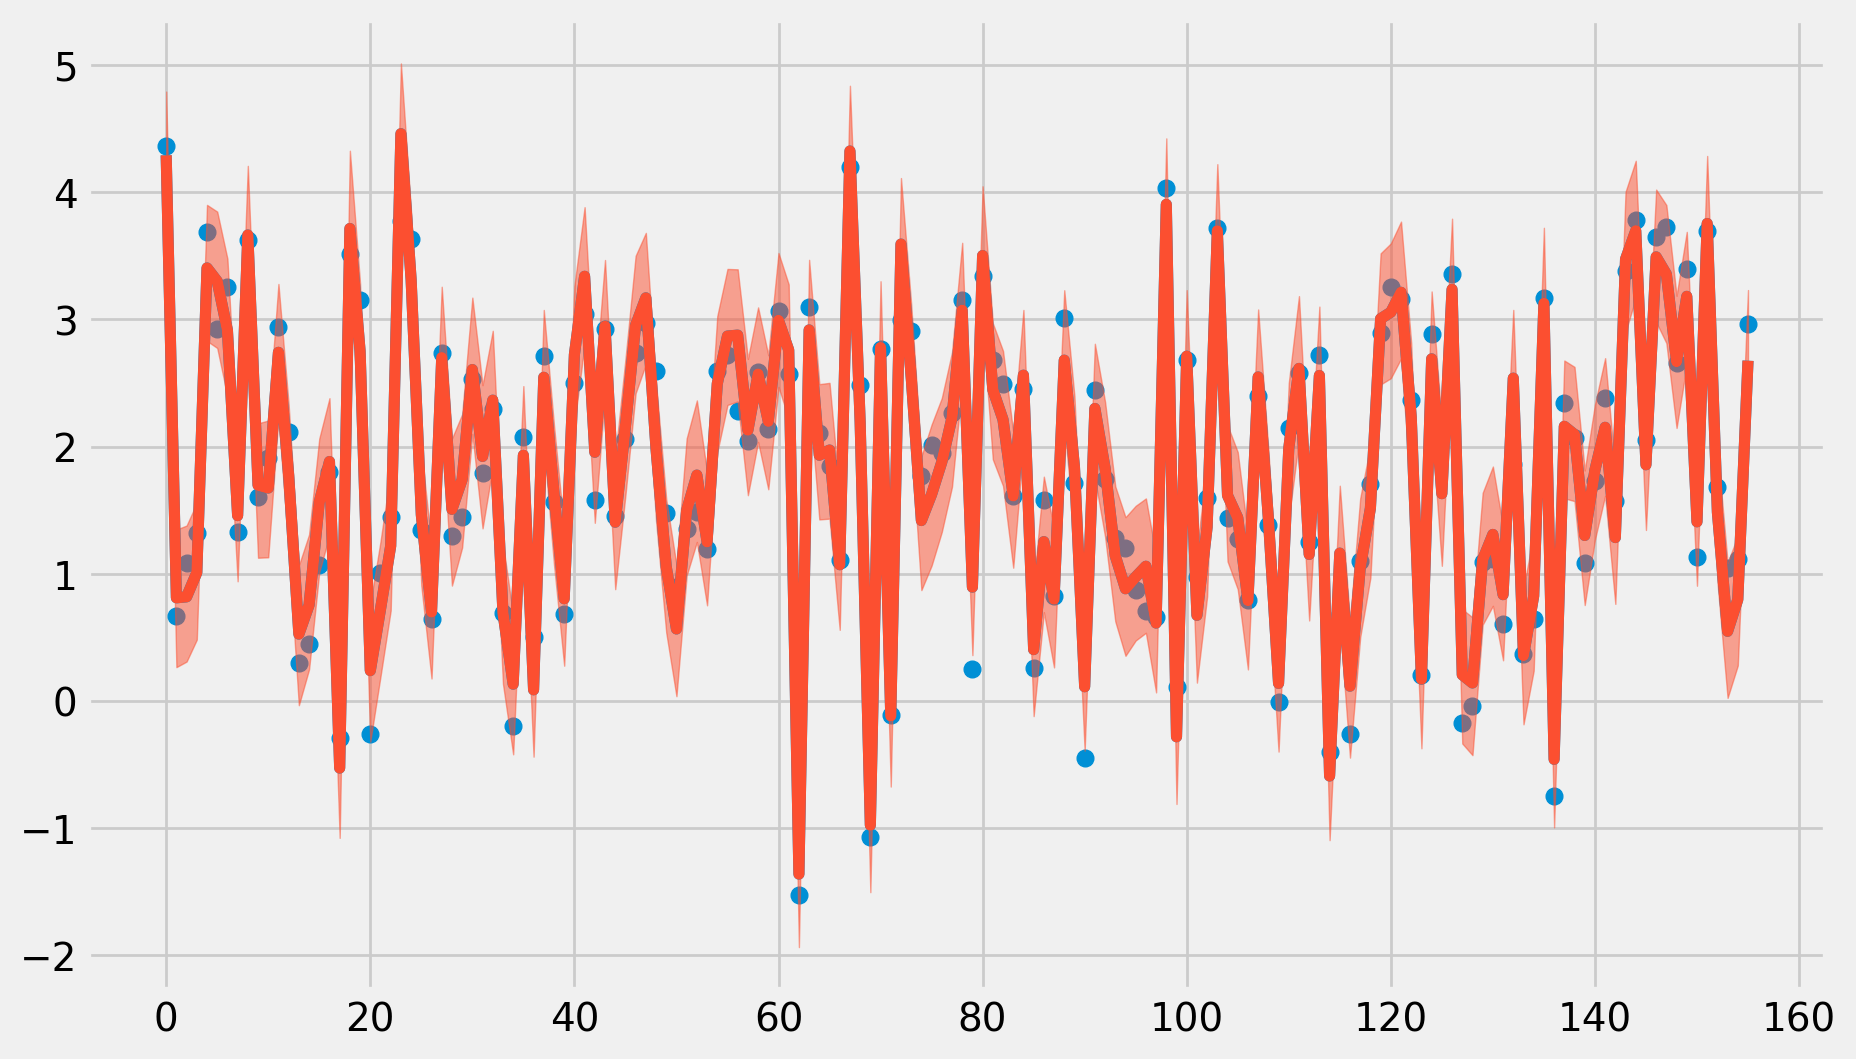

In [37]:
mu_para = posterior_para_predictive.posterior_predictive['mu']
if multiplicative:
  y_para_mean = np.exp(mu_para).mean(('chain', 'draw'))
else:
  y_para_mean = mu_para.mean(('chain', 'draw'))
if multiplicative:
  y_para = np.exp(posterior_para_predictive.posterior_predictive['y'])
else:
  y_para = posterior_para_predictive.posterior_predictive['y']

plt.plot(np.arange(156), y_para.median(('chain', 'draw')).values)
plt.plot(np.arange(156), y_para.median(('chain', 'draw')).values)
plt.scatter(np.arange(156), y)
pm.plot_hdi(np.arange(156), y_para, hdi_prob=.95, smooth=False)

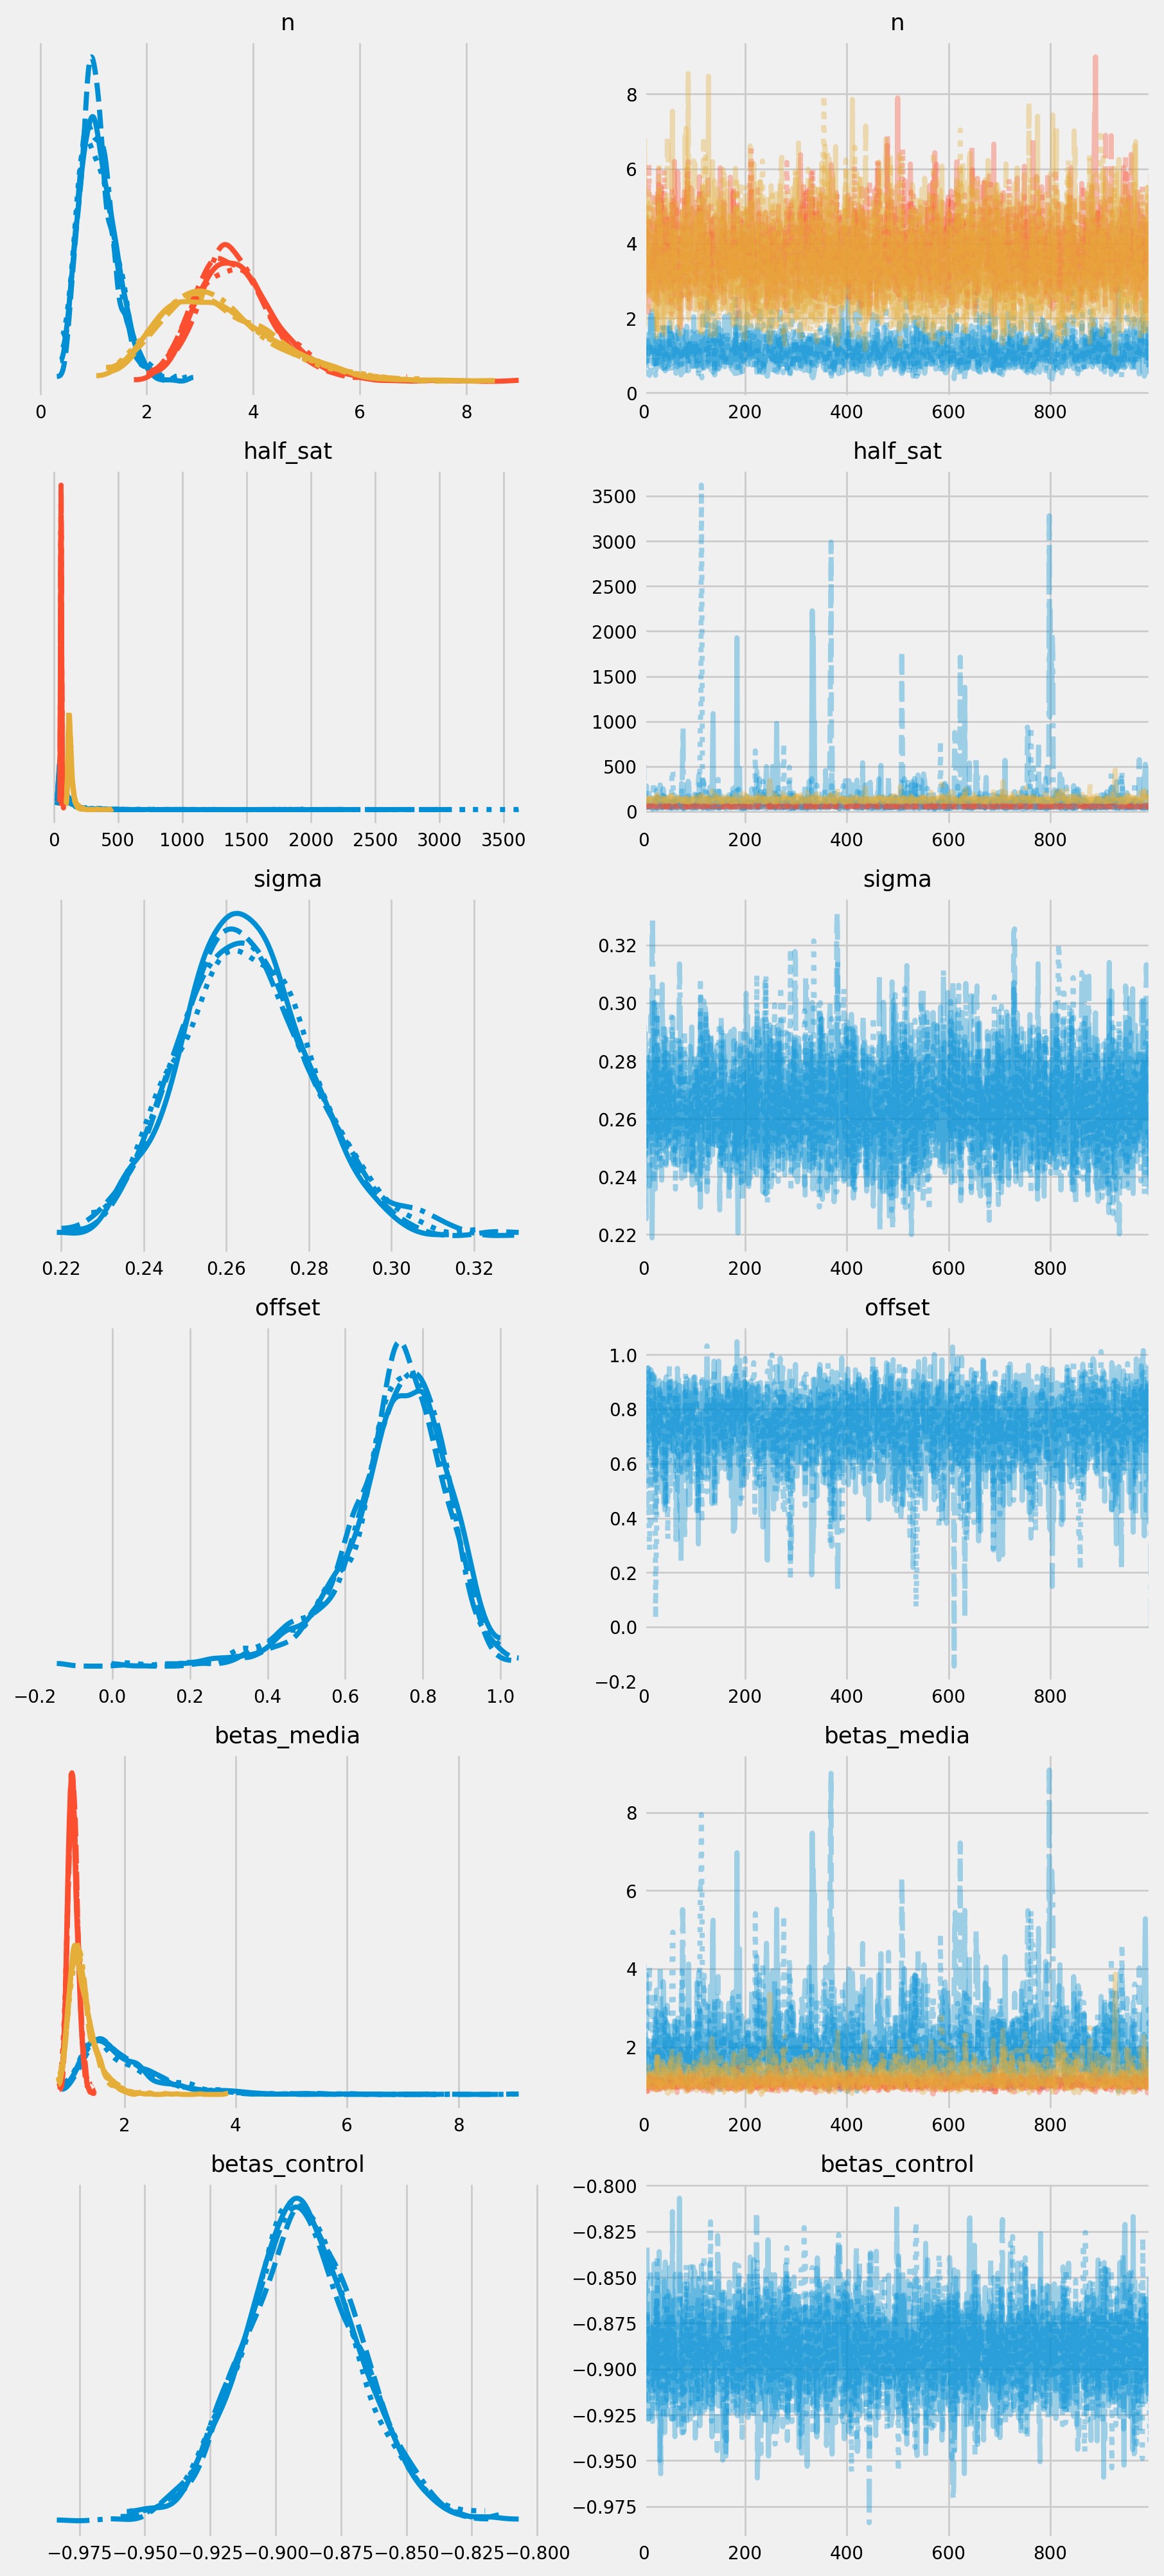

In [38]:
pm.plot_trace(trace_para, var_names=["n", 'half_sat', "sigma", 'offset', 'betas_media', 'betas_control'], figsize=(10, 24));

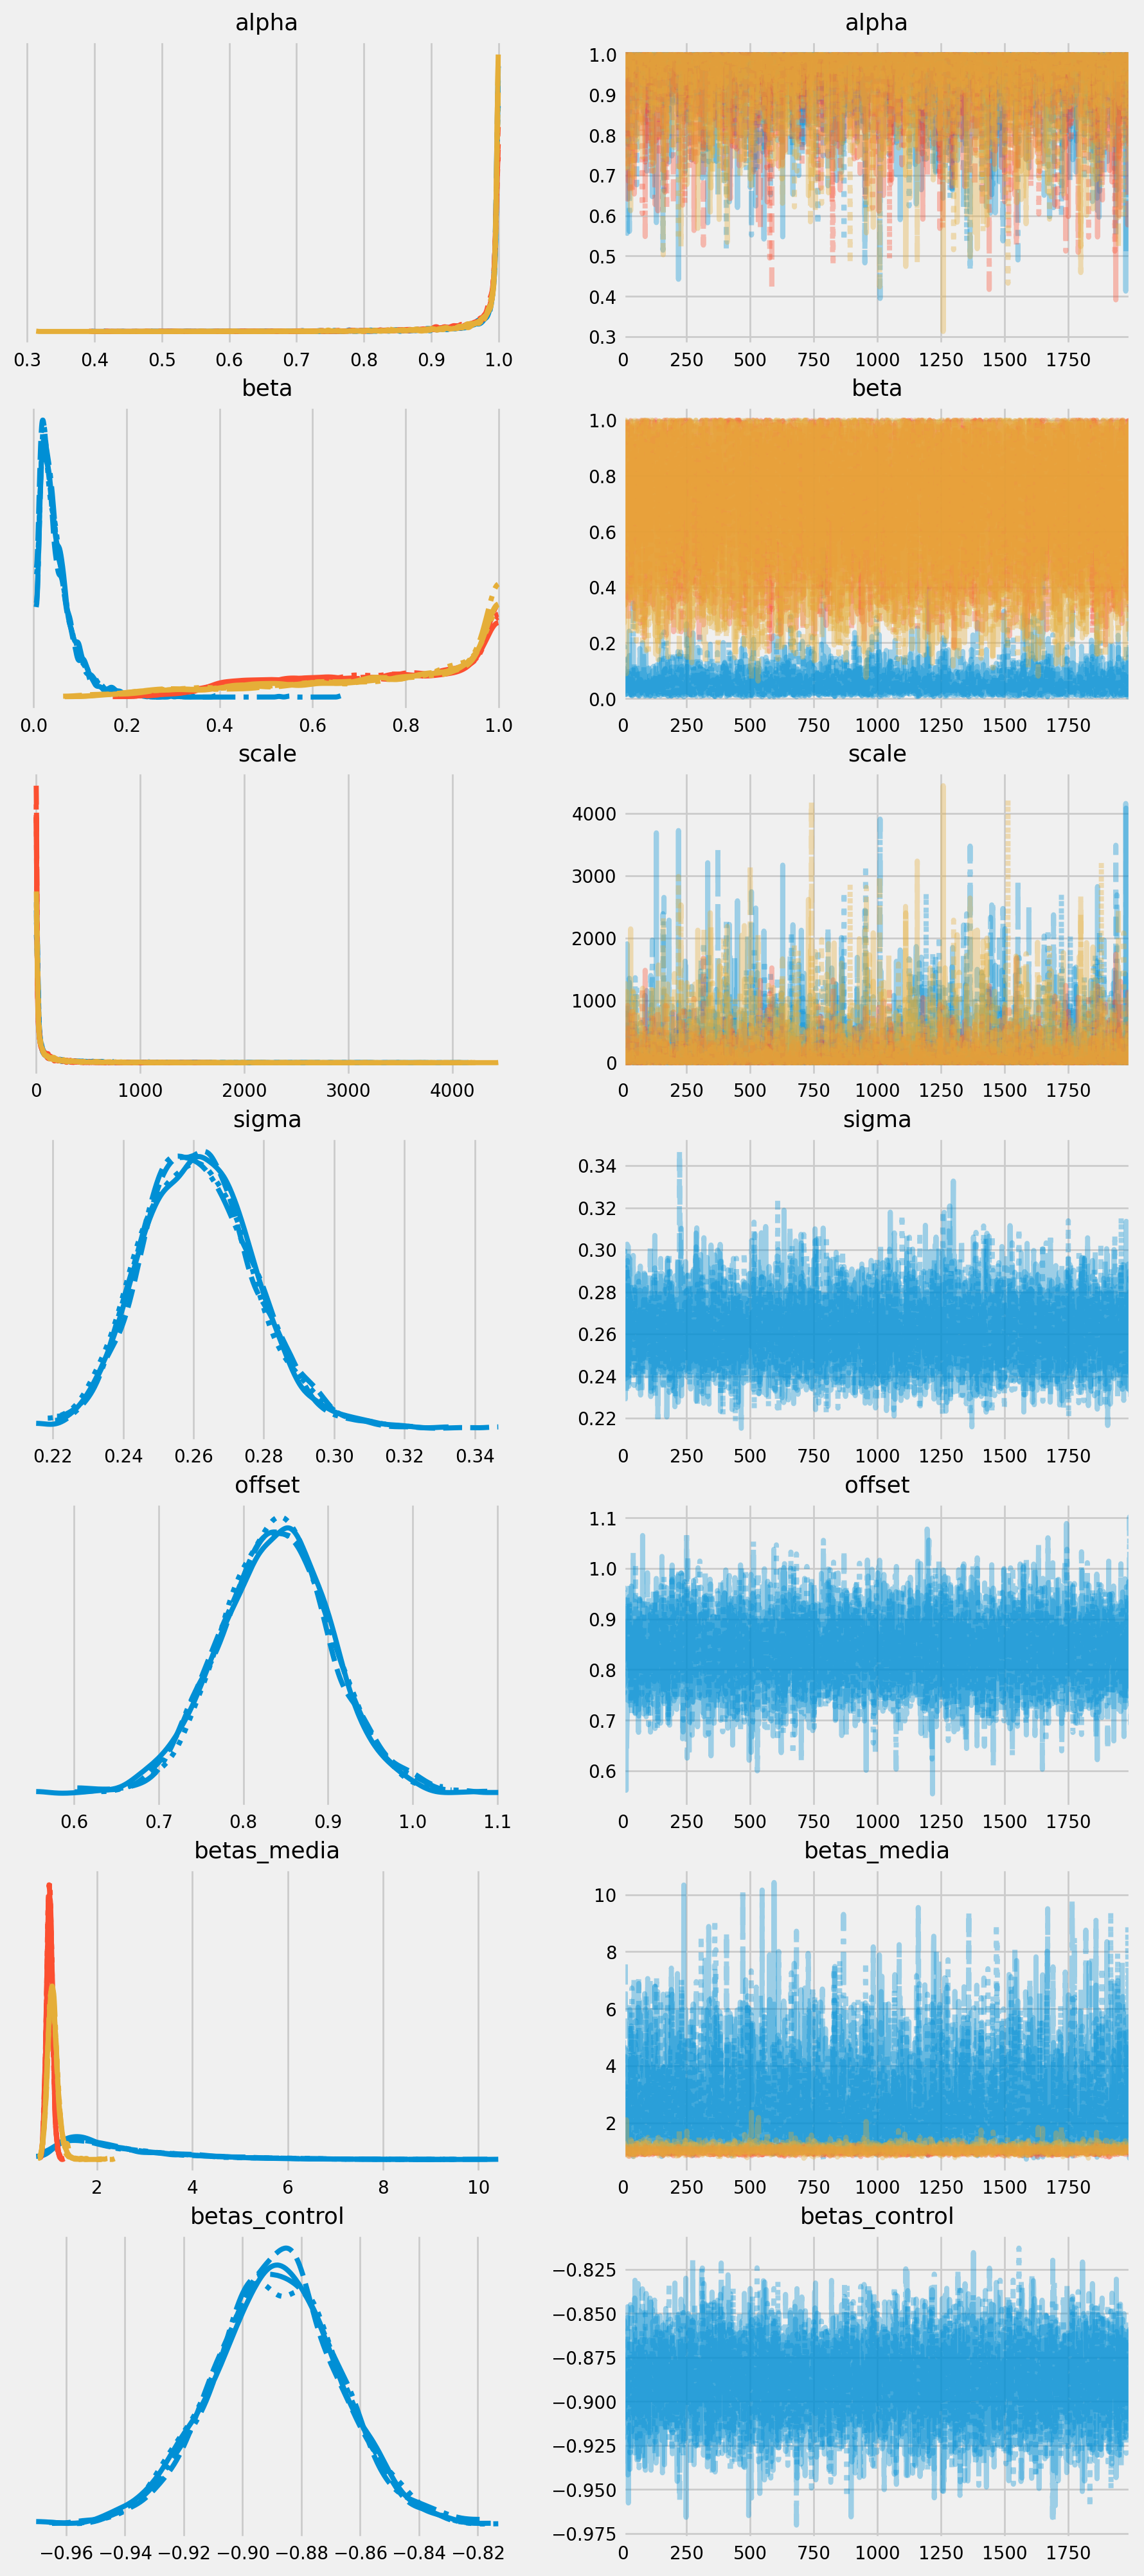

In [39]:
pm.plot_trace(trace_para_false, var_names=["alpha", "beta", 'scale', "sigma", 'offset', 'betas_media', 'betas_control'], figsize=(10, 24));

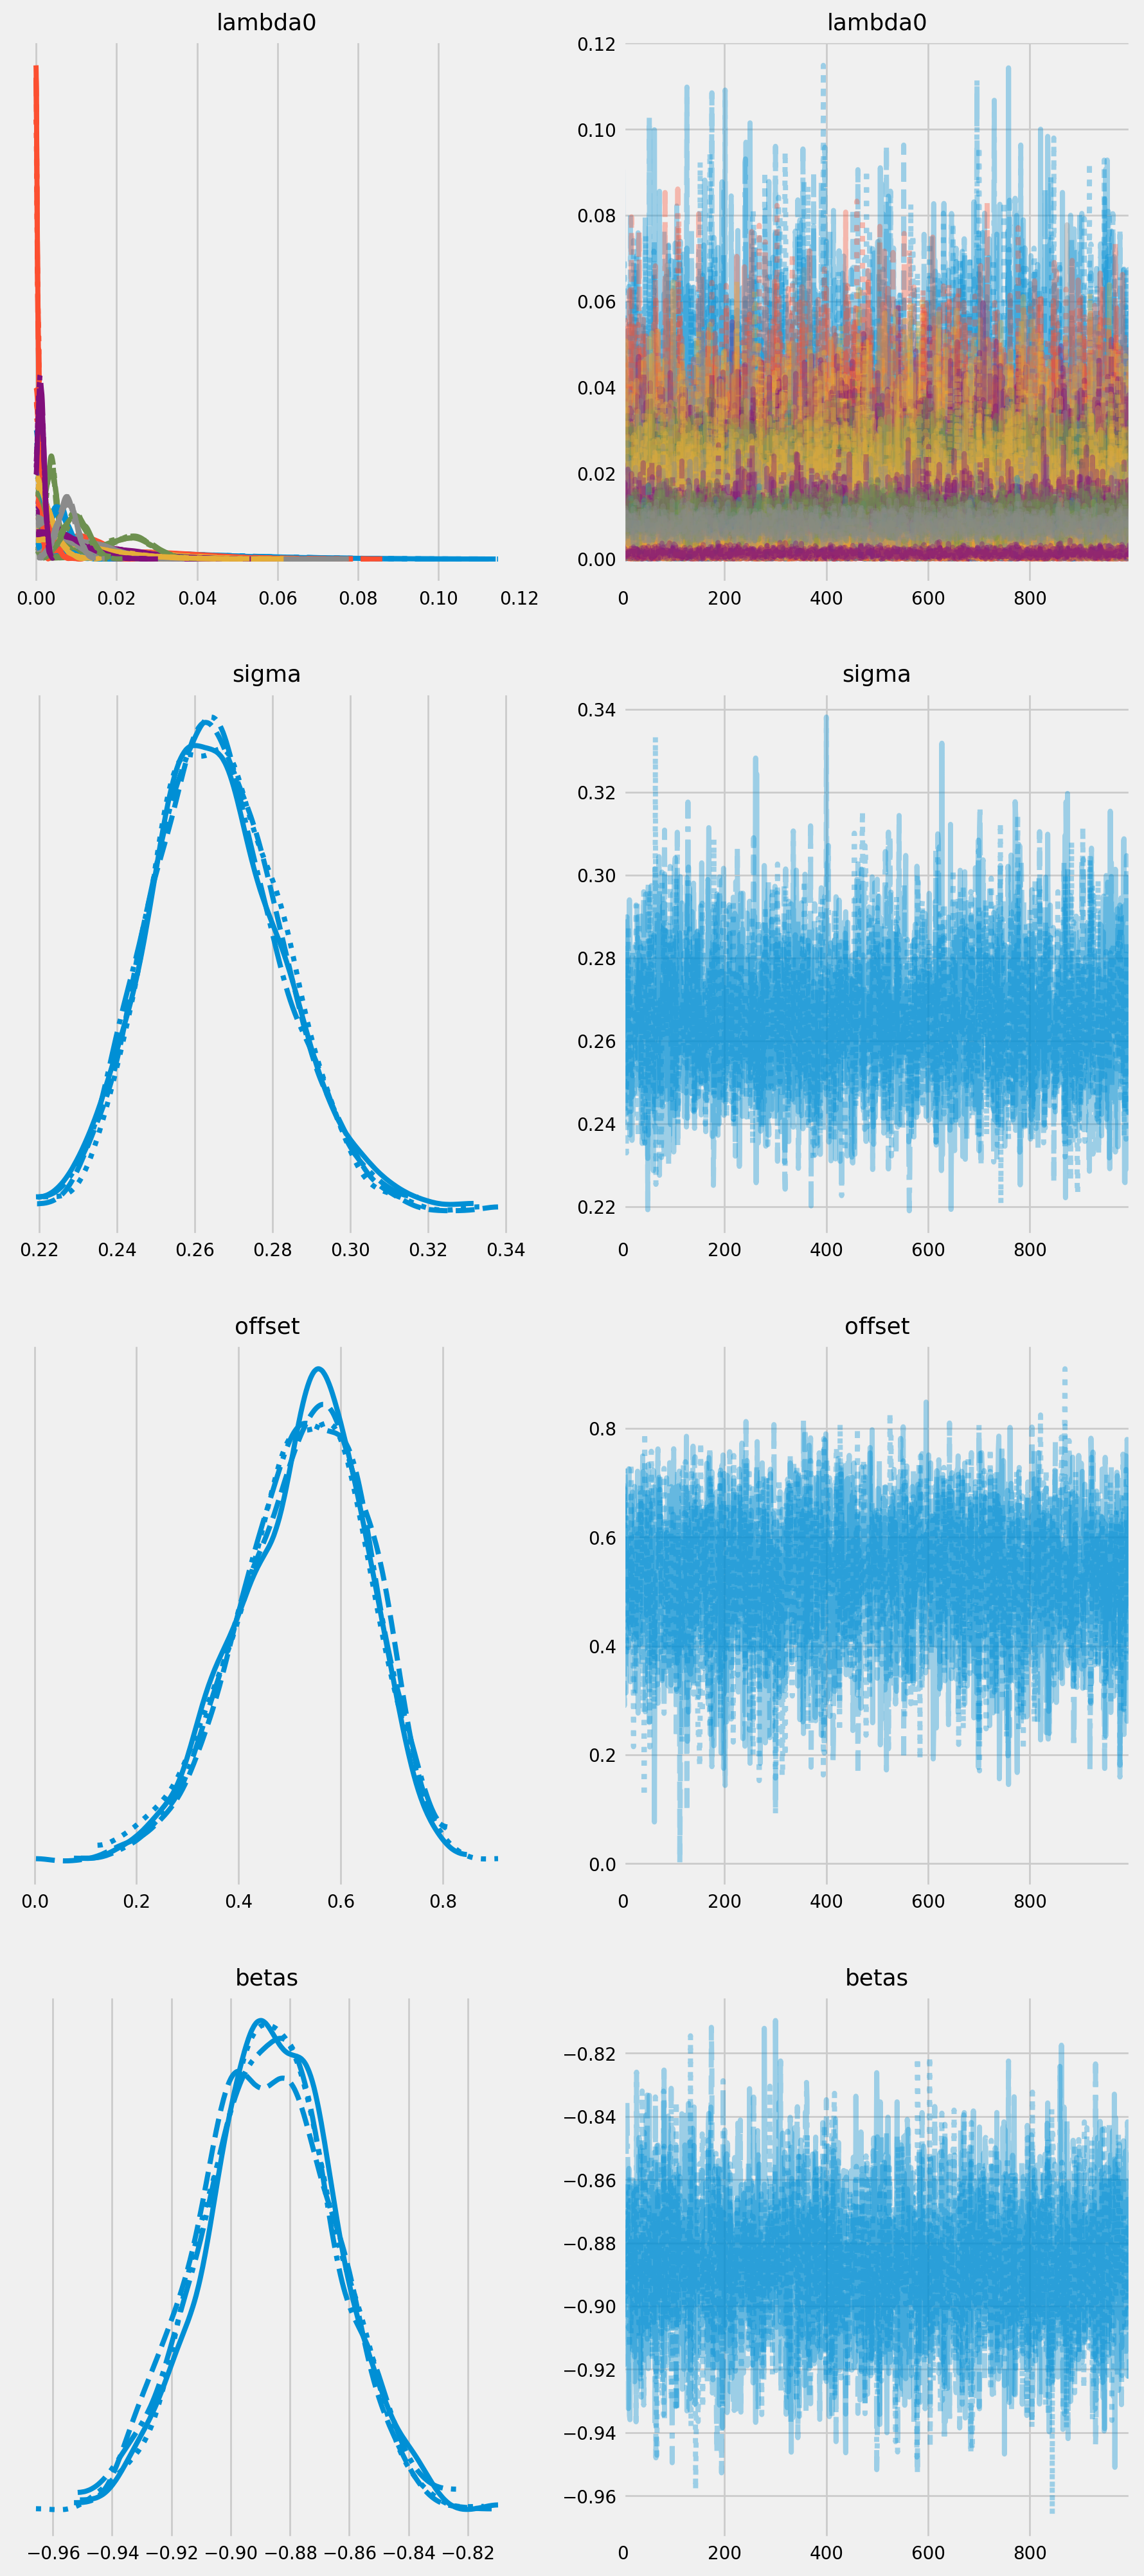

In [40]:
pm.plot_trace(trace, var_names=["lambda0", "sigma", 'offset', 'betas'], figsize=(10, 24));

/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/mattr/miniconda3/envs/streamlit_mlflow/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

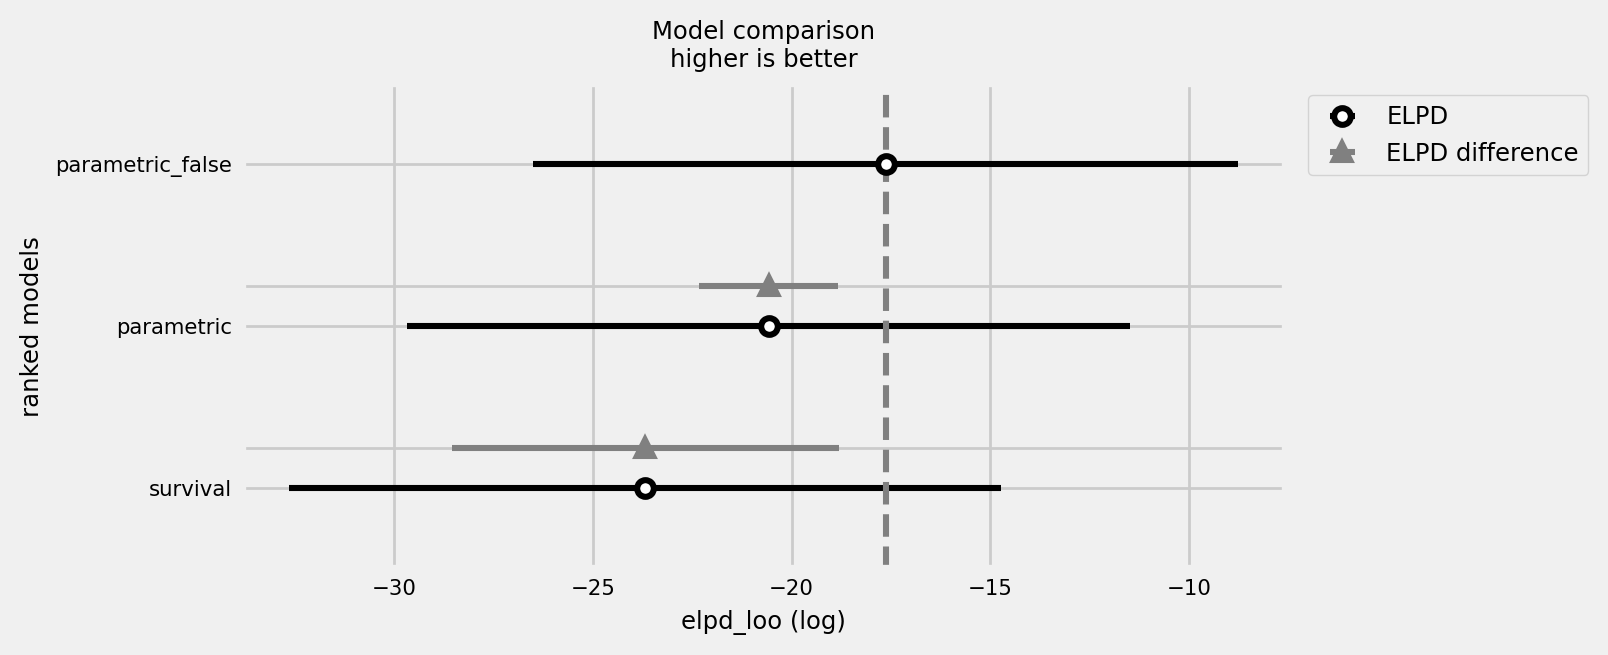

In [41]:
az.plot_compare(az.compare({'survival': trace, 'parametric': trace_para, 'parametric_false': trace_para_false}));

<Axes: >

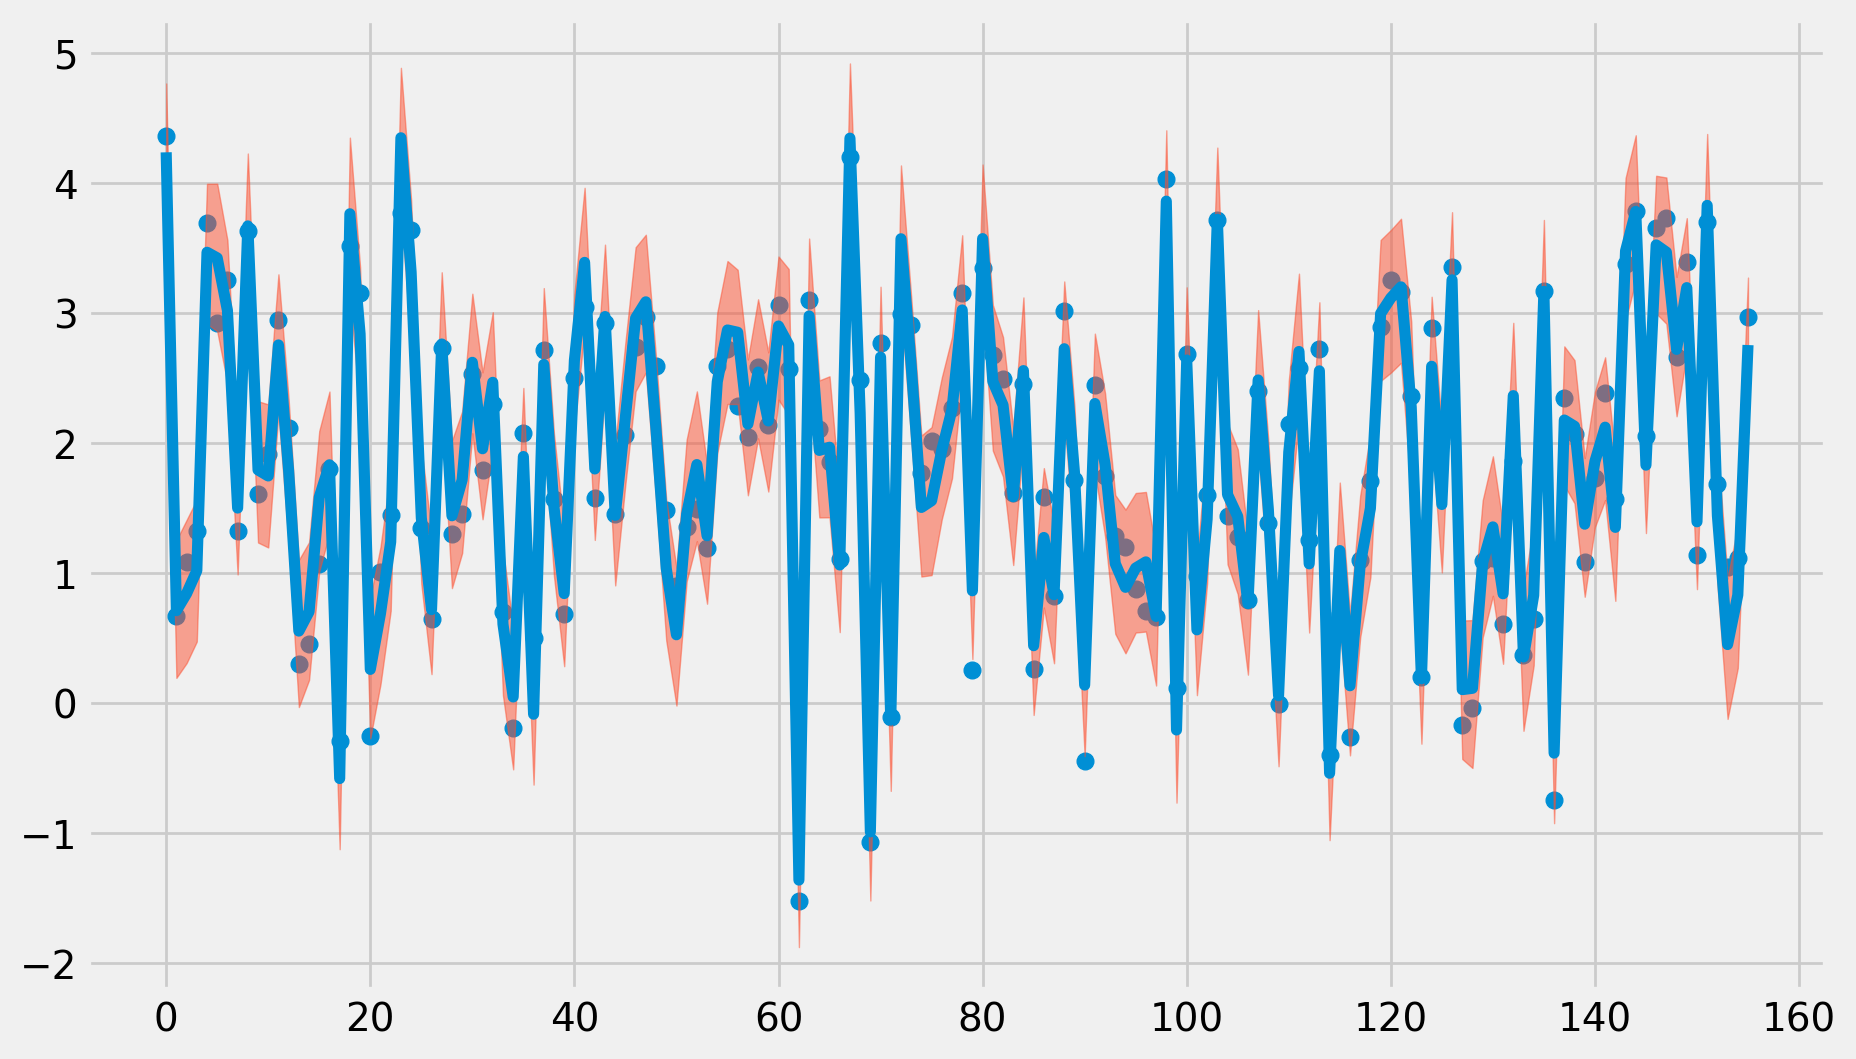

In [42]:
mu_para_mean = posterior_suvival_predictive.posterior_predictive['mu'].mean(('chain', 'draw'))
plt.plot(np.arange(156), posterior_suvival_predictive.posterior_predictive['y'].median(('chain', 'draw')).values)
plt.scatter(np.arange(156), y)
pm.plot_hdi(np.arange(156), posterior_suvival_predictive.posterior_predictive['y'], hdi_prob=.95, smooth=False)

In [43]:
trace_dirichlet.posterior['lambda0']

<xarray.DataArray 'lambda0' (chain: 4, draw: 10000, media_var: 3, intervals: 10)>
array([[[[0.24068066, 0.69455301, 0.27442684, ..., 0.85307127,
          0.15925507, 0.4929126 ],
         [0.09460804, 0.41063444, 0.36525674, ..., 0.42970894,
          0.47810443, 0.17623873],
         [0.12632539, 0.47920274, 0.1703187 , ..., 0.12197643,
          0.70199124, 0.06824454]],

        [[0.2402711 , 0.69477936, 0.27467592, ..., 0.8529884 ,
          0.15949691, 0.49290347],
         [0.09447315, 0.41034159, 0.36502467, ..., 0.43031043,
          0.47840594, 0.17639559],
         [0.12604692, 0.47783712, 0.17009019, ..., 0.1220293 ,
          0.70322798, 0.06817208]],

        [[0.2399522 , 0.69494454, 0.27482662, ..., 0.85278215,
          0.15930339, 0.49278725],
         [0.09436275, 0.41057282, 0.36548299, ..., 0.42910543,
          0.4772561 , 0.17695456],
         [0.1259334 , 0.47814298, 0.16992158, ..., 0.12228676,
          0.70113783, 0.06812948]],
...
        [[0.04612872, 0.09474425, 0.35755421, ..., 0.21589339,
          0.07374888, 0.12175803],
         [0.11966014, 0.38617898, 0.38034618, ..., 0.37649619,
          0.2529624 , 0.71541922],
         [0.04091516, 0.31550218, 0.3673447 , ..., 0.12703228,
          0.08322388, 0.32604576]],

        [[0.04537776, 0.09398678, 0.3587848 , ..., 0.21536276,
          0.07370704, 0.12149514],
         [0.11996539, 0.38187875, 0.38231981, ..., 0.37587865,
          0.25241287, 0.71570598],
         [0.04054308, 0.31384304, 0.36781694, ..., 0.12794582,
          0.08339451, 0.32628904]],

        [[0.04558395, 0.09554356, 0.35921604, ..., 0.21628151,
          0.07477202, 0.1215026 ],
         [0.12030368, 0.38017904, 0.37936258, ..., 0.37529904,
          0.25104712, 0.71524184],
         [0.04040631, 0.30869691, 0.36467979, ..., 0.12768681,
          0.08474967, 0.32553027]]]])
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * media_var  (media_var) <U3 'm_0' 'm_1' 'm_2'
  * intervals  (intervals) int64 0 1 2 3 4 5 6 7 8 9

In [118]:
base_hazard = trace_dirichlet.posterior["lambda0"]
media_effect = trace_dirichlet.posterior["media_effect"]
offset = trace_dirichlet.posterior["offset"]

In [119]:
interval_bounds

array([[2.67734119e-03, 6.70769087e-01, 1.34644274e-03, 2.01933144e-01],
       [2.35058742e+00, 6.31281599e+00, 2.56270542e+00, 3.70876555e+00],
       [3.73108617e+00, 1.56847467e+01, 5.39347531e+00, 7.48272761e+00],
       [6.57454656e+00, 2.32946698e+01, 8.90538003e+00, 9.30628805e+00],
       [8.99508448e+00, 3.47341275e+01, 1.46439402e+01, 1.32081197e+01],
       [1.12649376e+01, 4.79405566e+01, 1.81948465e+01, 1.62453585e+01],
       [1.34346150e+01, 5.95384096e+01, 2.19602263e+01, 1.81407728e+01],
       [1.60101831e+01, 6.64763997e+01, 2.84233857e+01, 2.40516039e+01],
       [1.94831154e+01, 8.13544384e+01, 3.28038248e+01, 2.52521678e+01],
       [2.52089586e+01, 1.03736387e+02, 3.96218794e+01, 3.18813083e+01],
       [2.85399379e+01, 1.17663633e+02, 4.92346549e+01, 3.59755843e+01],
       [3.70095662e+01, 1.29120743e+02, 5.88857713e+01, 4.37611235e+01],
       [4.27705762e+01, 1.61227591e+02, 7.31626420e+01, 5.26123161e+01],
       [5.47624818e+01, 1.89806955e+02, 1.09062911e

In [120]:
base_hazard.cumsum(dim='intervals')

<xarray.DataArray 'lambda0' (chain: 4, draw: 1000, media_var: 4, intervals: 15)>
array([[[[1.68016388e-01, 1.85250212e-01, 5.73513977e-01, ...,
          9.99686602e-01, 9.99980005e-01, 1.00000000e+00],
         [3.82577713e-02, 3.97833334e-01, 4.08197212e-01, ...,
          9.98875446e-01, 9.98985706e-01, 1.00000000e+00],
         [4.11004294e-02, 3.12533139e-01, 3.89136894e-01, ...,
          9.66685396e-01, 9.97803694e-01, 1.00000000e+00],
         [9.40772346e-02, 3.91721514e-01, 5.15208219e-01, ...,
          9.96906312e-01, 9.99999995e-01, 1.00000000e+00]],

        [[1.06166443e-02, 1.27693988e-01, 2.94598220e-01, ...,
          9.71481388e-01, 9.71920687e-01, 1.00000000e+00],
         [3.55908240e-02, 4.91243941e-02, 2.94389741e-01, ...,
          9.90252364e-01, 9.95174761e-01, 1.00000000e+00],
         [6.89291125e-02, 3.06565244e-01, 4.12211511e-01, ...,
          9.85318699e-01, 9.88209479e-01, 1.00000000e+00],
         [8.37080697e-02, 1.16167293e-01, 2.39885364e-01, ...,
          8.78742847e-01, 9.82272981e-01, 1.00000000e+00]],

        [[3.79622490e-04, 2.11670212e-02, 1.11323064e-01, ...,
          8.62066278e-01, 9.50728018e-01, 1.00000000e+00],
...
         [3.34269255e-05, 1.31579545e-01, 3.04841555e-01, ...,
          8.51880432e-01, 9.07224753e-01, 1.00000000e+00]],

        [[1.09037464e-01, 1.80750547e-01, 3.12112856e-01, ...,
          9.51911250e-01, 9.51912752e-01, 1.00000000e+00],
         [3.38277509e-04, 3.38277509e-04, 1.16270121e-03, ...,
          9.39031996e-01, 9.99555945e-01, 1.00000000e+00],
         [4.70007571e-02, 5.48134039e-02, 5.79080599e-02, ...,
          9.40935859e-01, 9.52500633e-01, 1.00000000e+00],
         [3.28885479e-01, 3.94311496e-01, 4.36323446e-01, ...,
          9.78904173e-01, 9.99854025e-01, 1.00000000e+00]],

        [[5.42139220e-02, 1.88846321e-01, 2.73715272e-01, ...,
          9.43642151e-01, 9.50164051e-01, 1.00000000e+00],
         [4.80132808e-03, 4.80132808e-03, 4.82588539e-03, ...,
          8.43186985e-01, 9.86788675e-01, 1.00000000e+00],
         [6.28594744e-04, 4.26084086e-01, 4.53669707e-01, ...,
          9.95208095e-01, 9.97641213e-01, 1.00000000e+00],
         [3.00706891e-03, 2.82907833e-01, 2.86386995e-01, ...,
          9.40263854e-01, 9.41527096e-01, 1.00000000e+00]]]])
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * media_var  (media_var) <U3 'm_0' 'm_1' 'm_2' 'm_3'
  * intervals  (intervals) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

In [121]:
media_effect.mean(('chain', 'draw'))

<xarray.DataArray 'media_effect' (media_var: 4)>
array([0.09834784, 0.05874347, 0.11343265, 0.26500852])
Coordinates:
  * media_var  (media_var) <U3 'm_0' 'm_1' 'm_2' 'm_3'

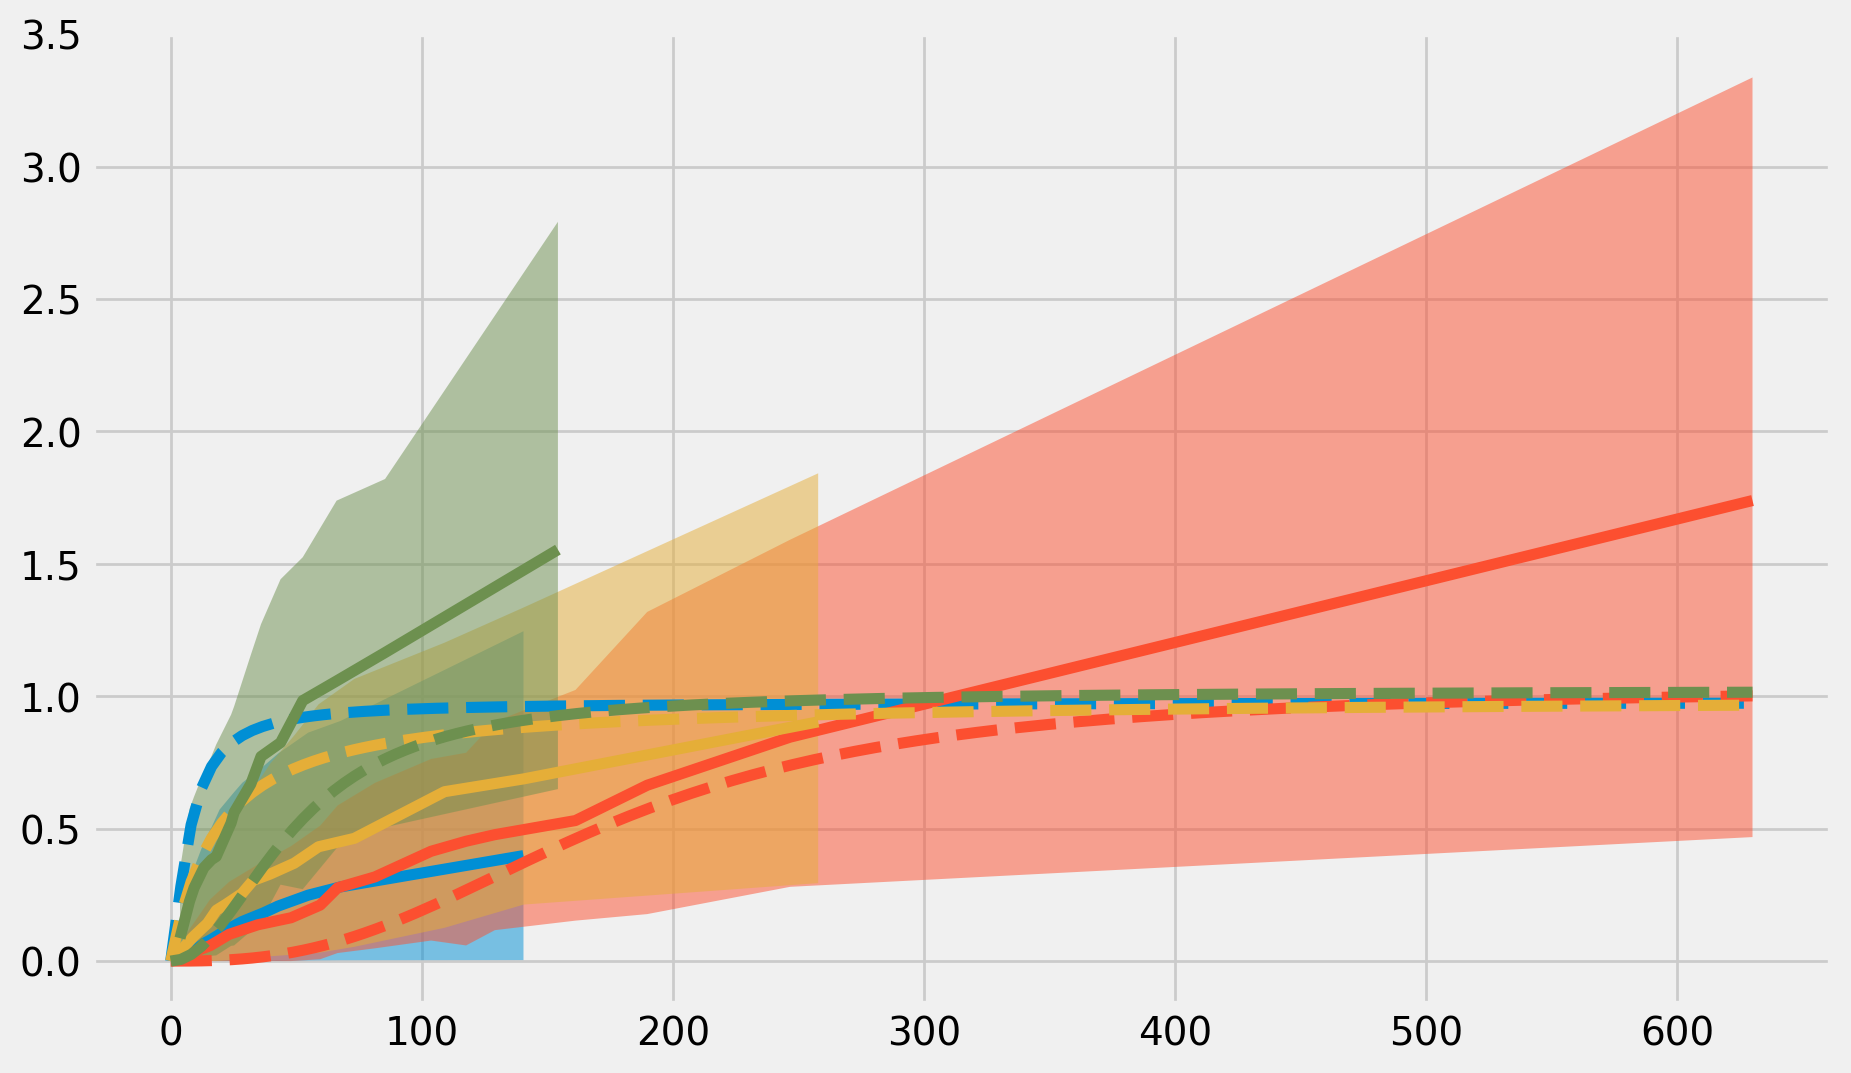

In [123]:
x_sim = np.linspace(0, X.max(), 156)
for i in range(n_media_vars):  
  cum_haz = (cum_hazard(base_hazard, interval_bounds)[:, :, i, :]*media_effect[:, :, i]).values
  hdi = pm.hdi(cum_haz, hdi_prob=.95)[:, :]
  low = hdi[:,0]
  upper = hdi[:, 1]
  plt.fill_between(interval_bounds[1:, i], low, upper, alpha=.5, label=f"Media {i}")
  plt.plot(interval_bounds[1:, i], np.quantile(cum_haz, .5, axis=(0, 1)), label=f"Media {i}", color=f"C{i}")
  plt.plot(x_sim, x_sim**n[i]/(x_sim**n[i]+half_sat[i]**n[i])*beta[i], label=f"Media {i} (true)", color=f"C{i}", linestyle='--')
  #plt.scatter(X[:, i], y)

In [124]:
beta_para = trace_para.posterior["betas_media"]
beta_para_mean = beta_para.mean(("chain", "draw")).values
n_para = trace_para.posterior["n"]
n_para_mean = n_para.mean(("chain", "draw")).values
half_sat_para = trace_para.posterior["half_sat"]
half_sat_para_mean = half_sat_para.mean(("chain", "draw")).values

In [125]:
coeff_para_false = trace_para_false.posterior["betas_media"]
coeff_para_false_mean = coeff_para_false.mean(("chain", "draw")).values
alpha_para_false = trace_para_false.posterior["alpha"]
alpha_para_false_mean = alpha_para_false.mean(("chain", "draw")).values
beta_para_false = trace_para_false.posterior["beta"]
beta_para_false_mean = beta_para_false.mean(("chain", "draw")).values
scale_para_false = trace_para_false.posterior["scale"]
scale_para_false_mean = scale_para_false.mean(("chain", "draw")).values

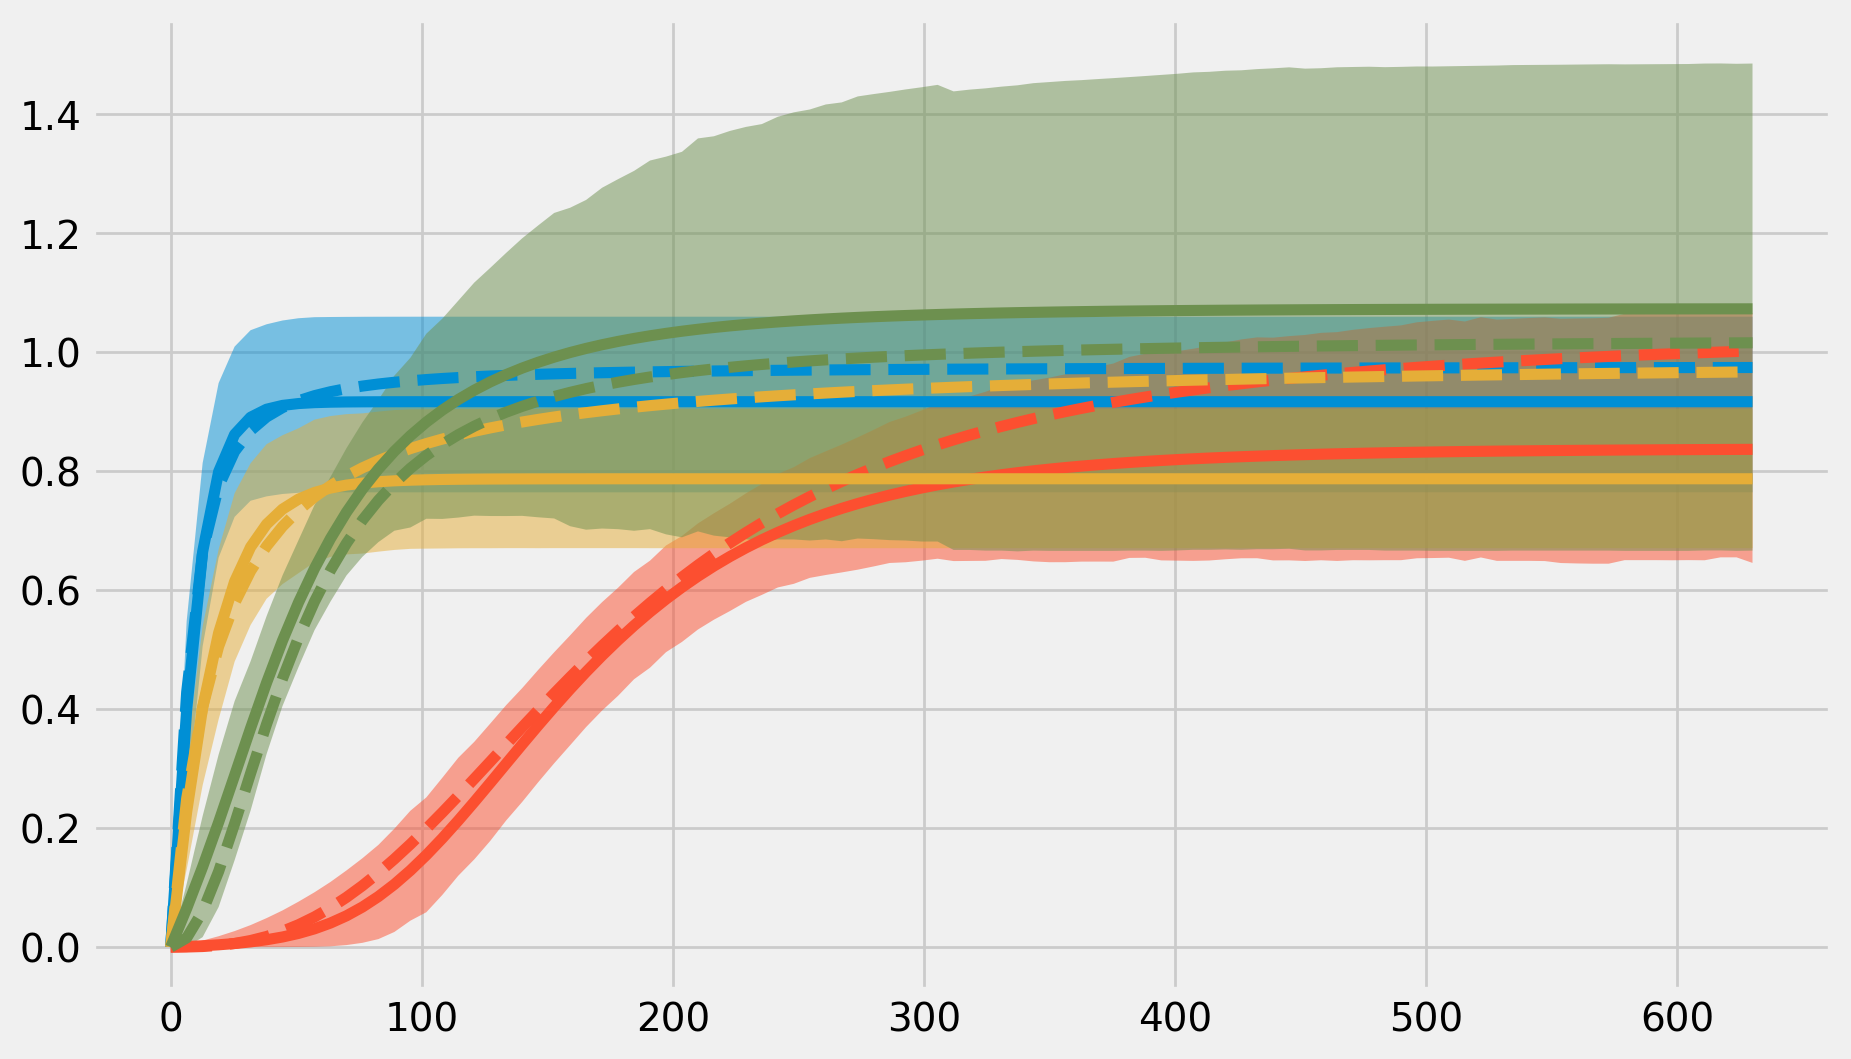

In [126]:
x_t = np.linspace(0, X.max(), 100)
s_origin_test = s_origin(x_t[:, np.newaxis, np.newaxis, np.newaxis], coeff_para_false.values, alpha_para_false.values, 10**(-10*beta_para_false.values), scale_para_false.values).transpose(1, 2, 0, 3)
s_origin_hdi = pm.hdi(s_origin_test, hdi_prob=.95)
s_origin_low = s_origin_hdi[:, :, 0]
s_origin_upper = s_origin_hdi[:, :, 1]
s_origin_test_mean = s_origin_test.mean(axis=(0, 1))
for i in range(n_media_vars):
  plt.fill_between(x_t, s_origin_low[:, i], s_origin_upper[:, i], alpha=.5, label=f"Media {i}")
  plt.plot(x_t, s_origin_test_mean[:, i], label=f"Media {i}", color=f"C{i}")
  plt.plot(x_t, x_t**n[i]/(x_t**n[i]+half_sat[i]**n[i])*beta[i], label=f"Media {i} (true)", color=f"C{i}", linestyle='--')
  #plt.scatter(X[:, i], y)

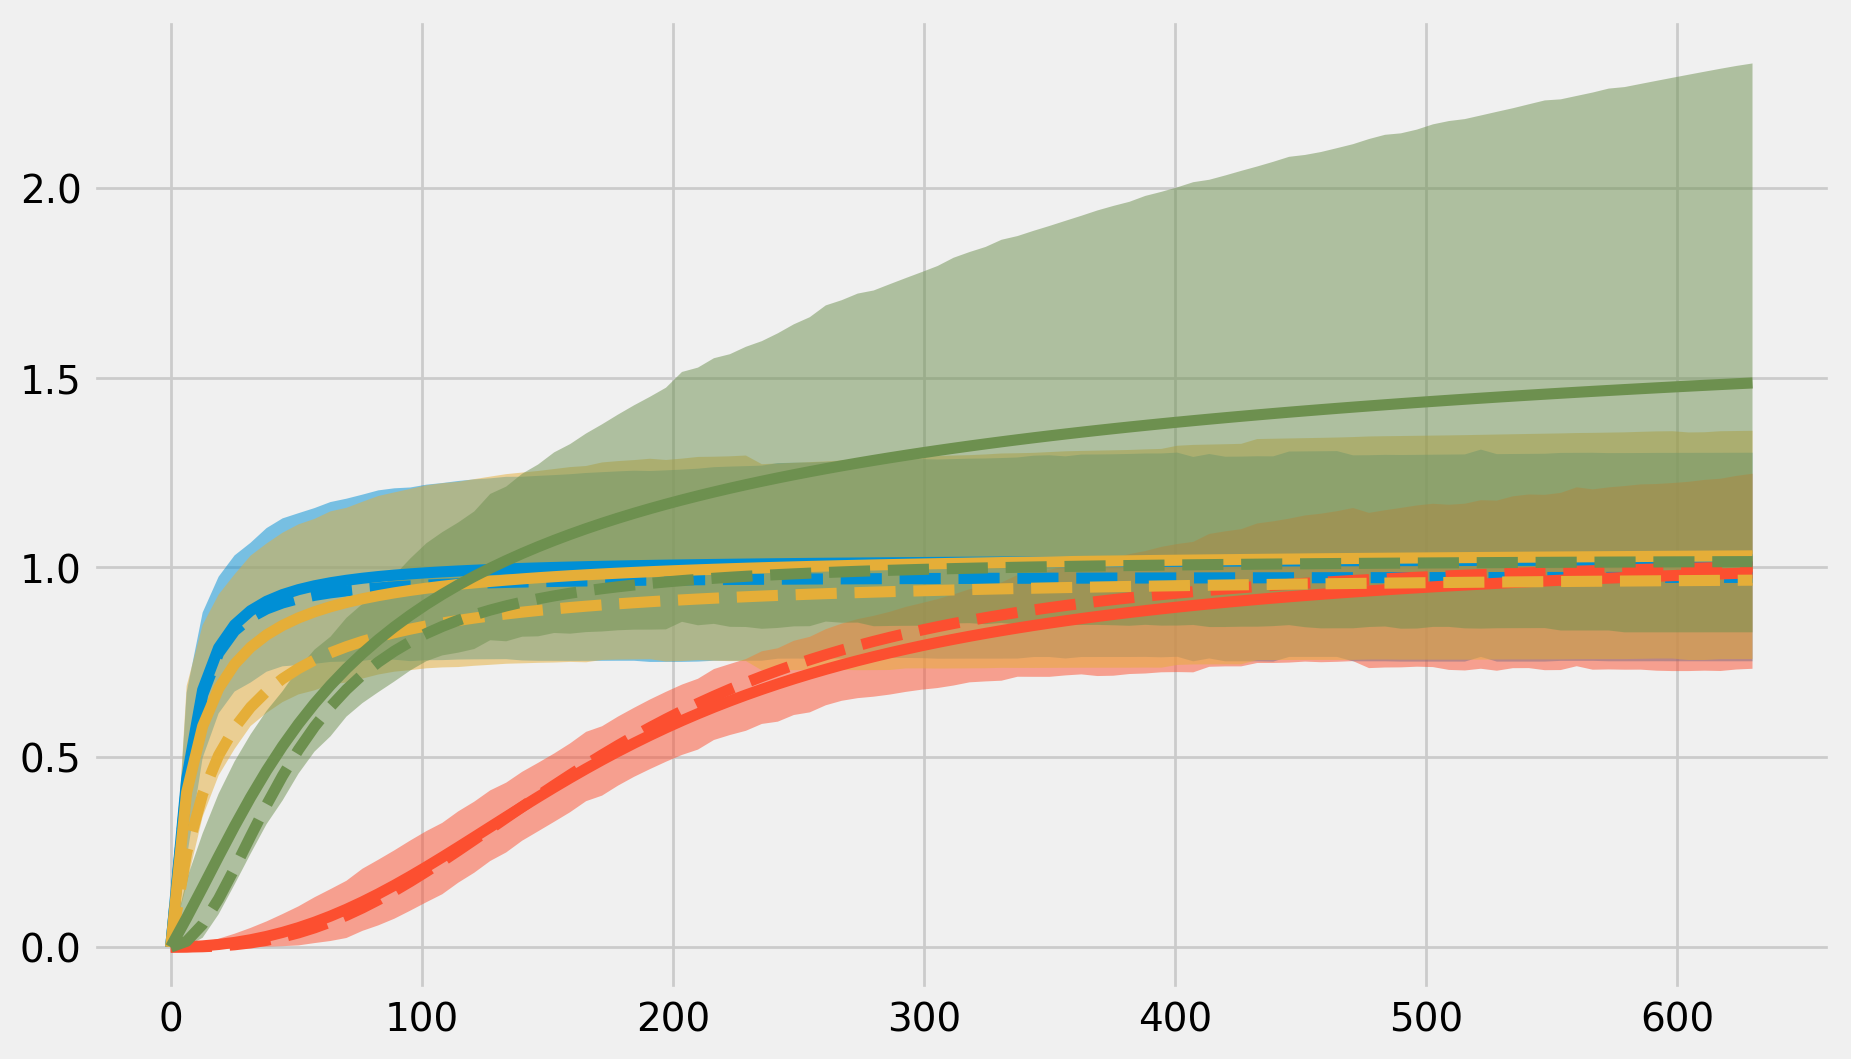

In [127]:
x_t = np.linspace(0, X.max(), 100)
hill_test = hill(x_t[:, np.newaxis, np.newaxis, np.newaxis], beta_para.values, half_sat_para.values, n_para.values).transpose(1, 2, 0, 3)
hill_hdi = pm.hdi(hill_test, hdi_prob=.95)
hill_low = hill_hdi[:, :, 0]
hill_upper = hill_hdi[:, :, 1]
hill_test_mean = hill_test.mean(axis=(0, 1))
for i in range(n_media_vars):
  plt.fill_between(x_t, hill_low[:, i], hill_upper[:, i], alpha=.5, label=f"Media {i}")
  plt.plot(x_t, hill_test_mean[:, i], label=f"Media {i}", color=f"C{i}")
  plt.plot(x_t, x_t**n[i]/(x_t**n[i]+half_sat[i]**n[i])*beta[i], label=f"Media {i} (true)", color=f"C{i}", linestyle='--')
  #plt.scatter(X[:, i], y)

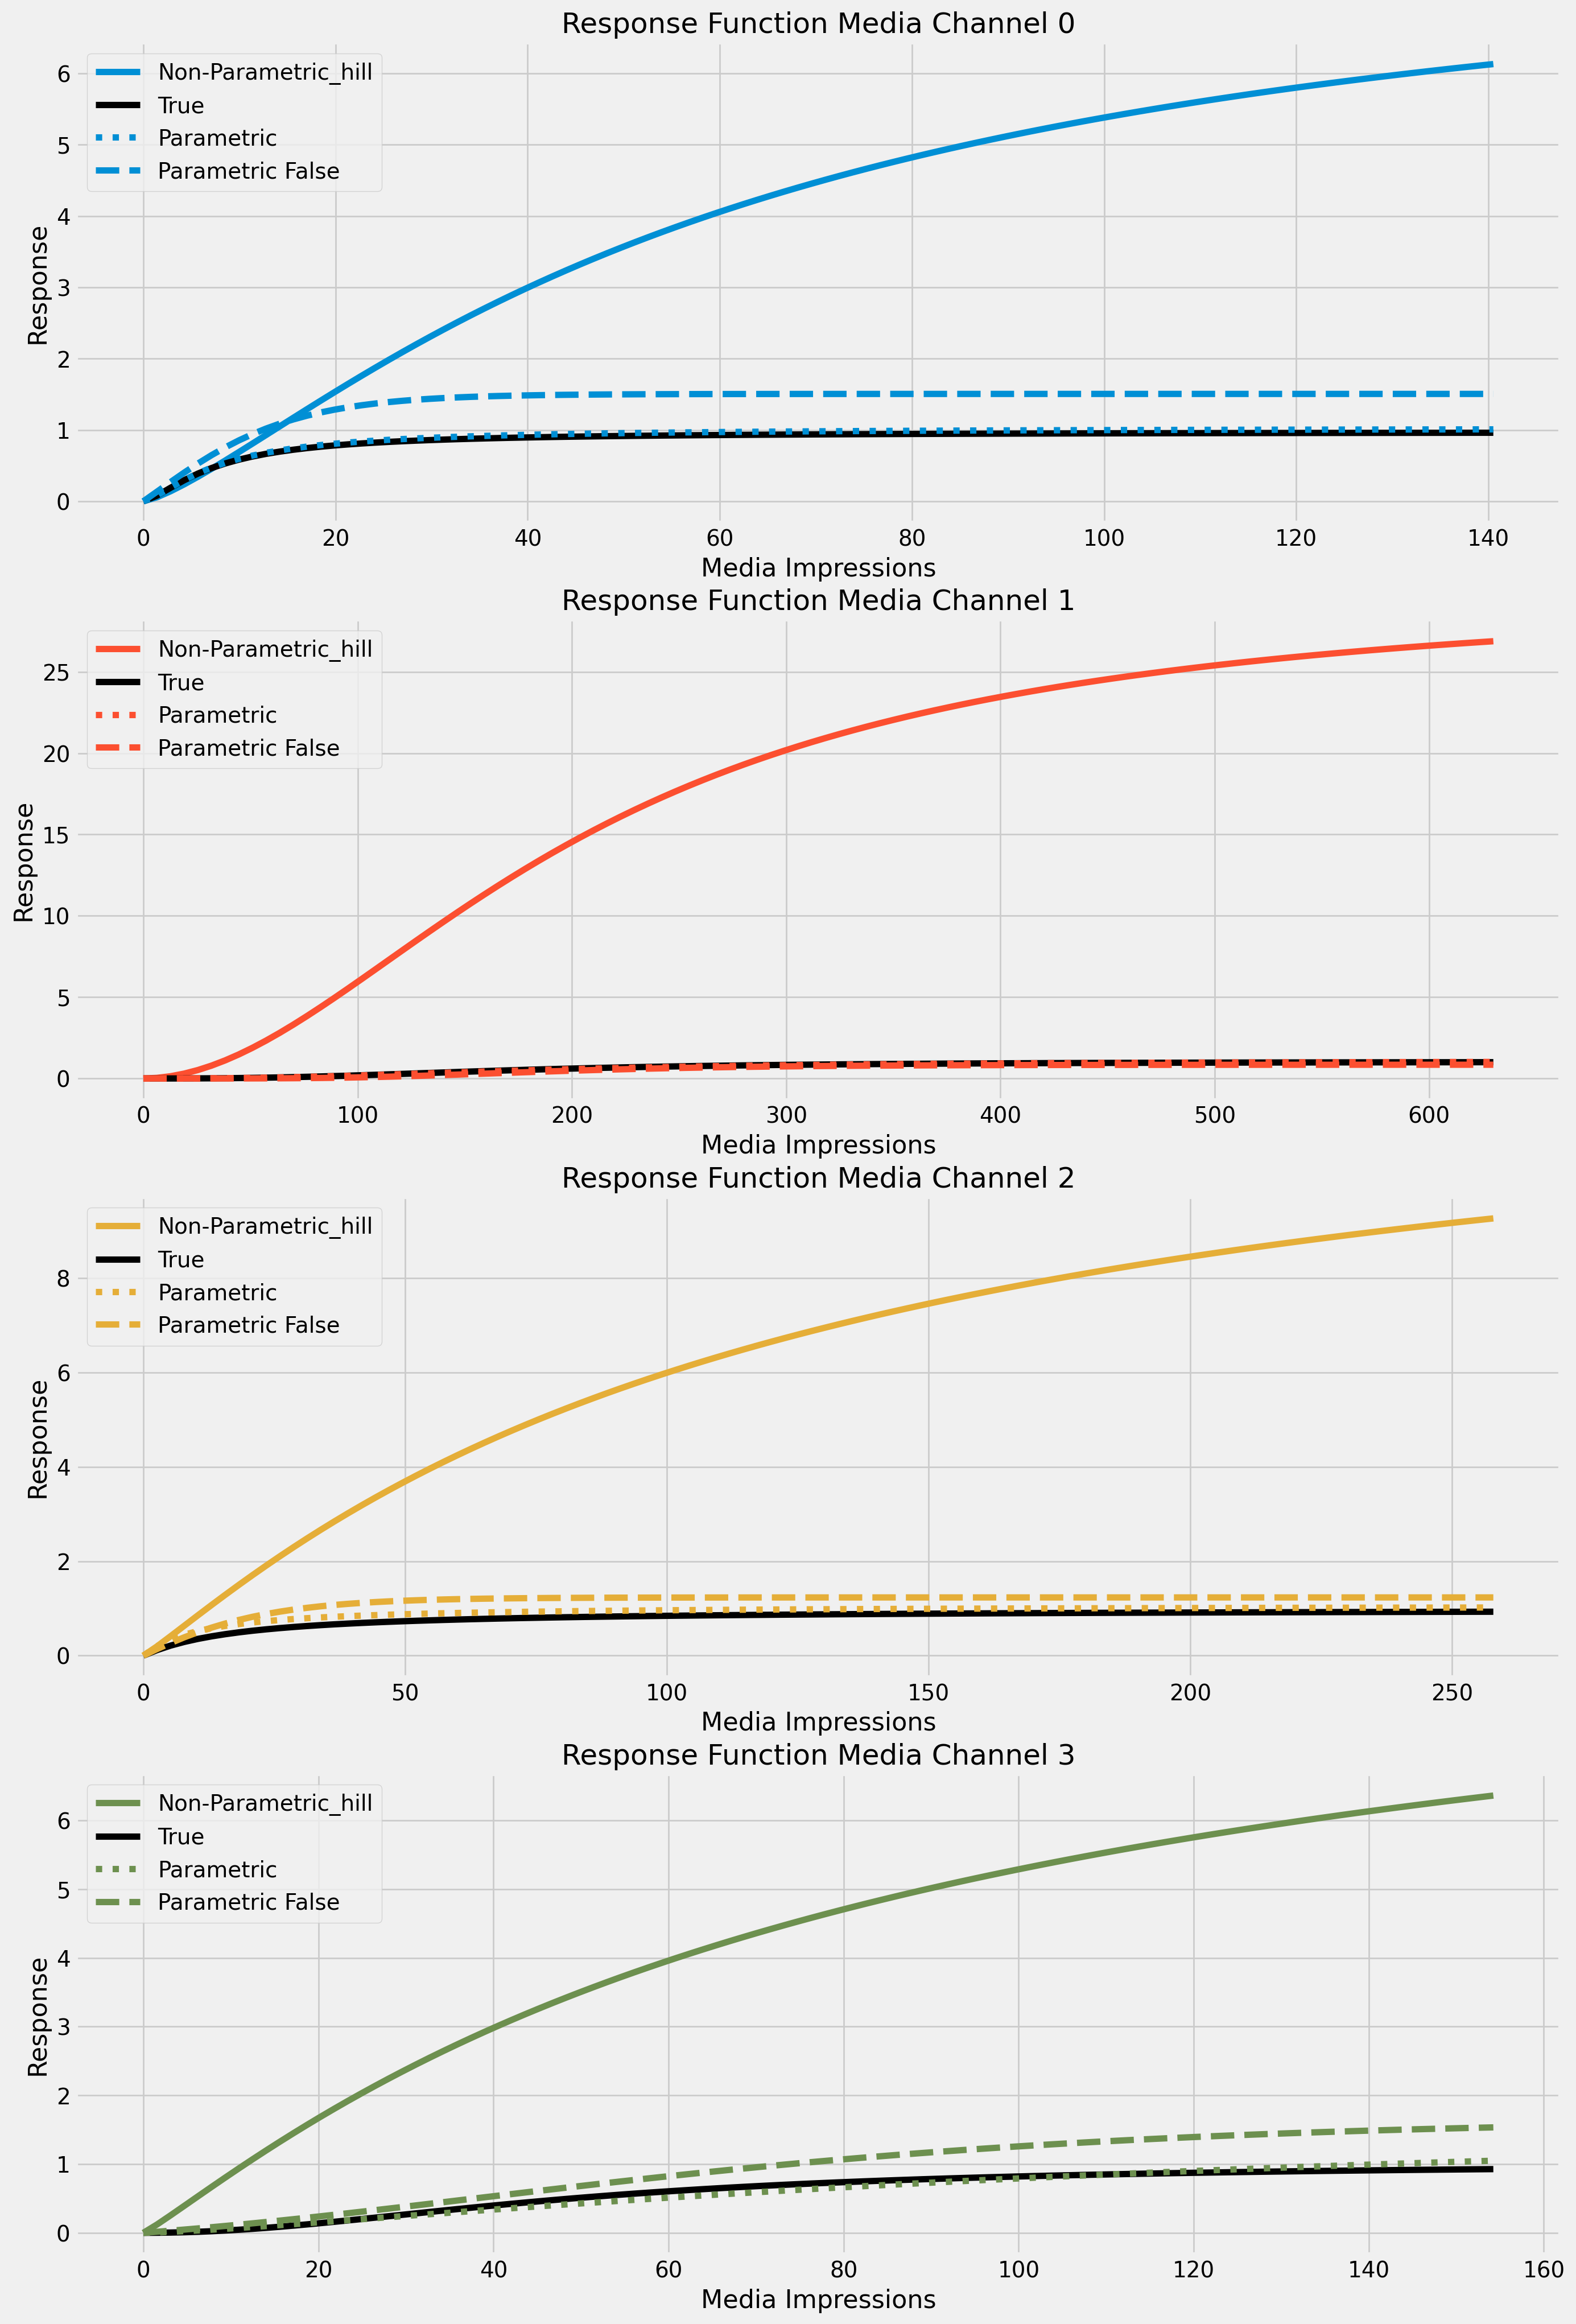

In [128]:
i = 0
fig, ax = plt.subplots(n_media_vars, figsize=(15, 6*n_media_vars))
better_s_origin = lambda x, c, a, b, s: s_origin(x, c, a, 10**(-b*10), s)
for i in range(n_media_vars):
  y_sim = cum_hazard(base_hazard, interval_bounds)[:, :, i, :].to_numpy().reshape(-1, n_intervals).flatten()
  X_bounds = np.tile(interval_bounds[1:, i].flatten(), (4, 1000, 1)).reshape(-1, n_intervals).flatten()
  fit_of_curve_hill, _ = curve_fit(hill, X_bounds, y_sim, p0=[5, X_bounds.mean(), 3], bounds=([0, 0, 1.1], [30, 1e5, 10]), maxfev=10000)
  fit_of_curve_s_origin, _ = curve_fit(s_origin, X_bounds, y_sim, p0=[5, 1, .94, 30], bounds=(0, [30, 10, 1, 1e4]), maxfev=10000)
  x_t = np.linspace(0, X[:, i].max(), 100)
  ax[i].plot(x_t, hill(x_t, *fit_of_curve_hill), label='Non-Parametric_hill', c=f'C{i}')
  #ax[i].plot(x_t, s_origin(x_t, *fit_of_curve_s_origin), label='Non-Parametric_s_origin', c=f'C{i}', ls='-.')
  ax[i].plot(x_t, hill(x_t, beta[i], half_sat[i], n[i]), label="True", c="k")
  ax[i].plot(x_t, hill(x_t, beta_para_mean[i], half_sat_para_mean[i], n_para_mean[i]), label="Parametric", c=f"C{i}", ls=':')
  ax[i].plot(x_t, s_origin(x_t, coeff_para_false_mean[i], alpha_para_false_mean[i], 10**(-10*beta_para_false_mean[i]), scale_para_false_mean[i]), label="Parametric False", c=f"C{i}", ls='--')
  ax[i].set_title(f"Response Function Media Channel {i}")
  ax[i].set_xlabel("Media Impressions")
  ax[i].set_ylabel("Response")
  ax[i].legend()

In [160]:
def test(x, y):
  return (np.exp(y+x)-np.exp(y))/(np.exp(y)-1)

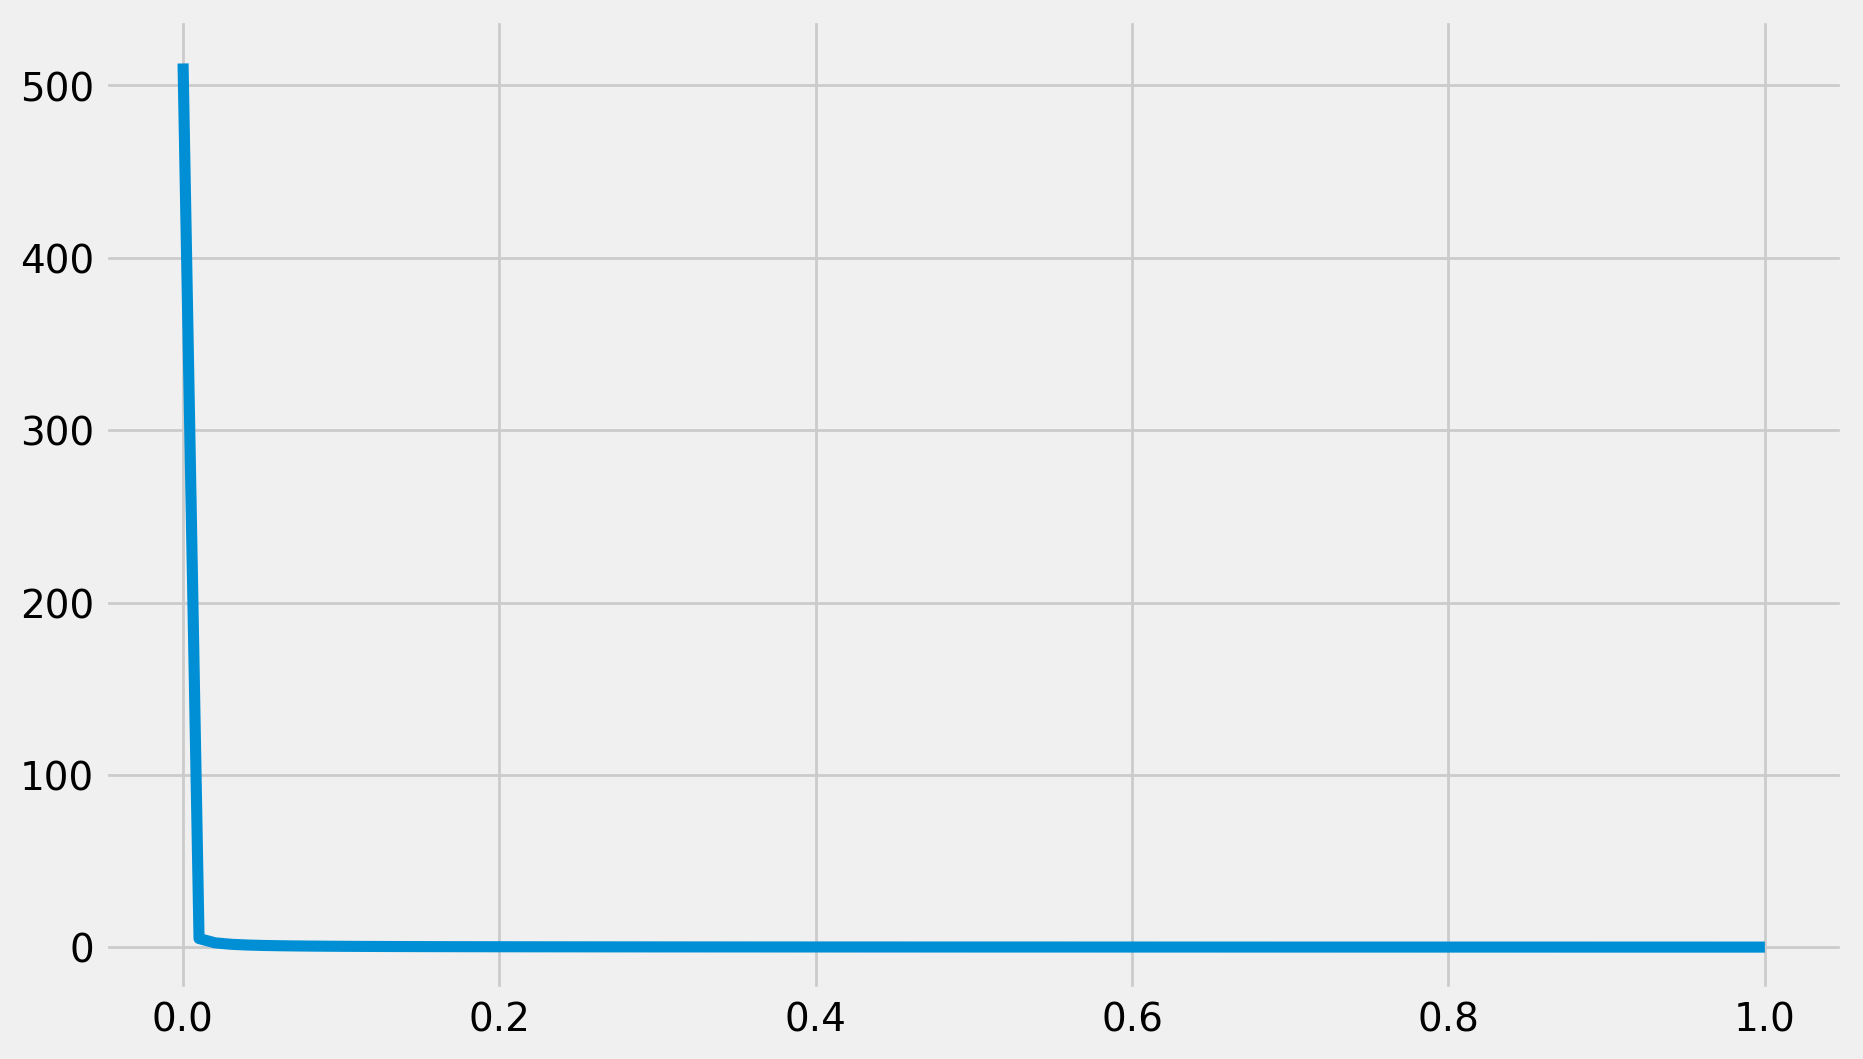

In [141]:
np.exp(.05)

1.0512710963760241